In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings(action='ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [20]:
official_data_path = './official_data/'
image_path = './images/'

In [5]:
iod = xr.open_dataset(official_data_path+'iod.nc')
sst = xr.open_dataset(official_data_path+'sst.anom.mon.mean.nc')
precip = xr.open_dataset(official_data_path+'precip.anom.mon.mean.nc')
vwind = xr.open_dataset(official_data_path+'vwnd.10m.anom.mon.mean.nc')
uwind = xr.open_dataset(official_data_path+'uwnd.10m.anom.mon.mean.nc')

# SST

In [6]:
sst

<xarray.Dataset>
Dimensions:  (time: 499, lon: 360, lat: 180)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2023-07-01
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Aug 25 15:39:59 2023: cdo -f nc import_binary sst.anom....
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

## 시계열

### 한개씩

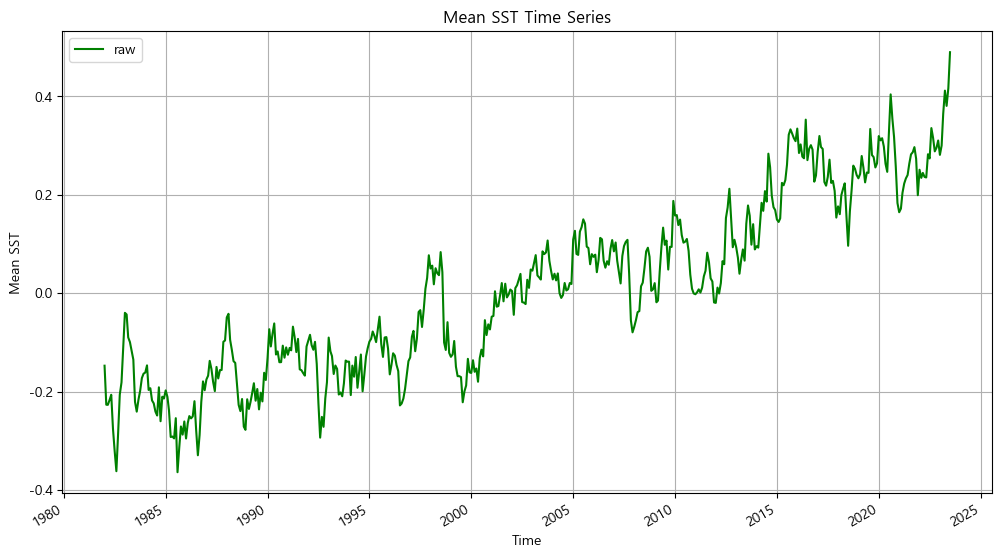

In [7]:
# 월별 SST 평균
sst_mean = sst['sst'].mean(dim=['lat', 'lon'])

# SST의 평균화된 시계열 그래프를 생성합니다.
fig = plt.figure(figsize=(12, 6))
sst_mean.plot.line(x='time', linestyle='-', c='g', label='raw')

plt.title(f'Mean SST Time Series')
plt.xlabel('Time')
plt.ylabel('Mean SST')
plt.legend()
plt.grid(True)
plt.show()


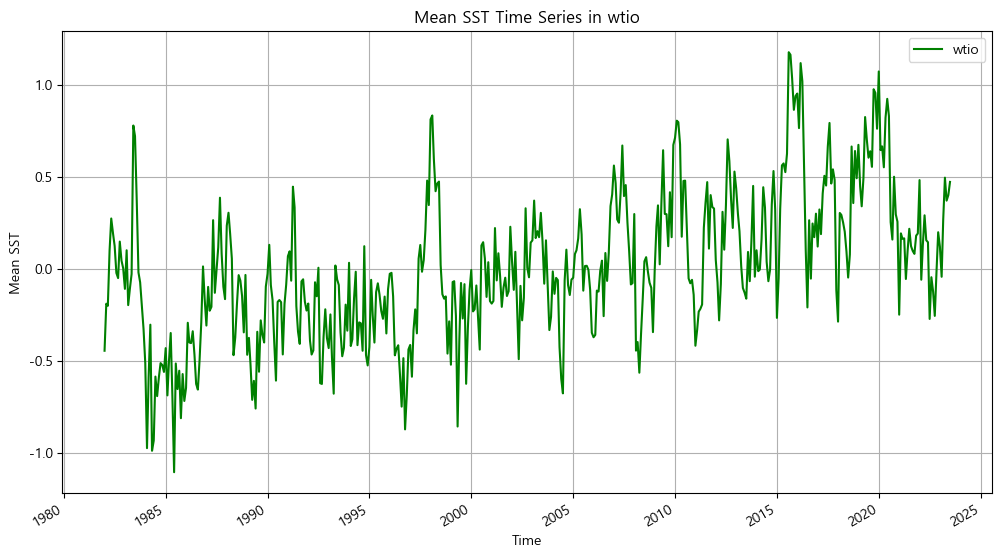

In [8]:
# wtio
# 선택한 위도 및 경도 범위 내에서의 SST를 추출합니다.
min_lat, max_lat, min_lon, max_lon = -10, 10, 50, 70
sst_wtio = sst['sst'].sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))

# 선택한 범위 내에서 SST를 평균화합니다.
wtio_mean = sst_wtio.mean(dim=['lat', 'lon'])

# SST의 평균화된 시계열 그래프를 생성합니다.
fig = plt.figure(figsize=(12, 6))
wtio_mean.plot.line(x='time', linestyle='-', c='g', label='wtio')

plt.title(f'Mean SST Time Series in wtio')
plt.xlabel('Time')
plt.ylabel('Mean SST')
plt.legend()
plt.grid(True)
plt.show()


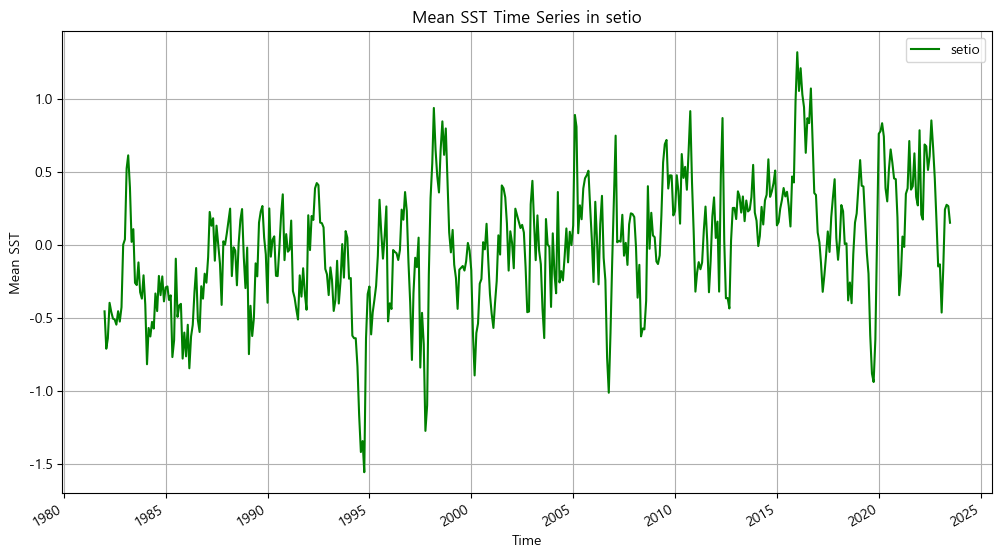

In [9]:
# setio
# 선택한 위도 및 경도 범위 내에서의 SST를 추출합니다.
min_lat, max_lat, min_lon, max_lon = -10, 0, 90, 110
sst_setio = sst['sst'].sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))

# 선택한 범위 내에서 SST를 평균화합니다.
setio_mean = sst_setio.mean(dim=['lat', 'lon'])

# SST의 평균화된 시계열 그래프를 생성합니다.
fig = plt.figure(figsize=(12, 6))
setio_mean.plot.line(x='time', linestyle='-', c='g', label='setio')

plt.title(f'Mean SST Time Series in setio')
plt.xlabel('Time')
plt.ylabel('Mean SST')
plt.legend()
plt.grid(True)
plt.show()

### 한번에

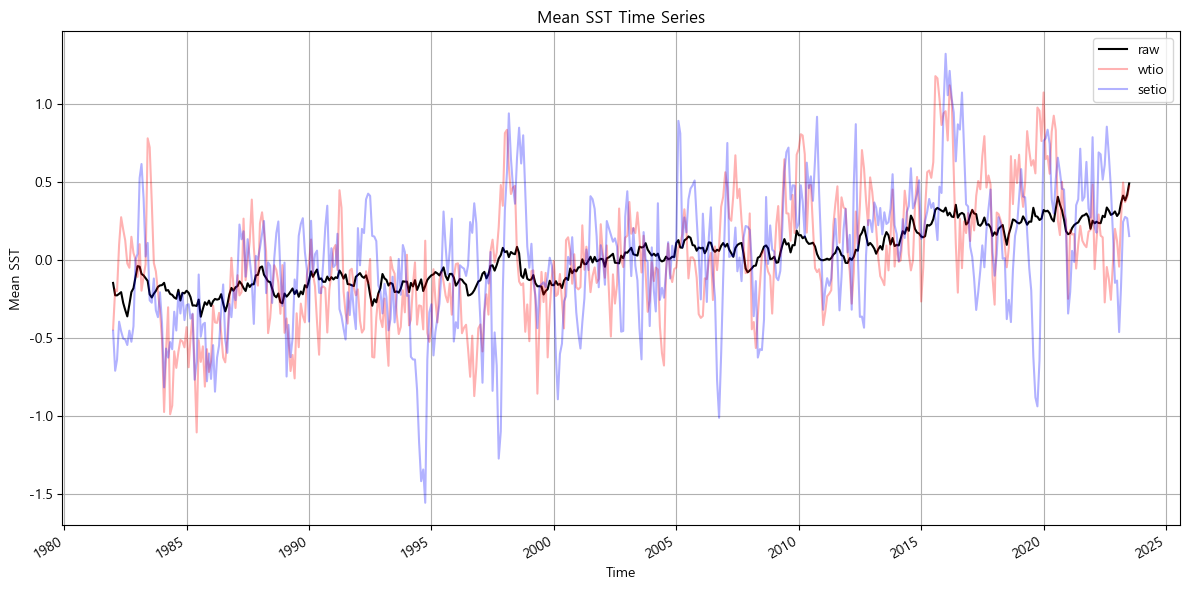

In [10]:
# SST 평균화
sst_mean_total = sst['sst'].mean(dim=['lat', 'lon'])

# wtio
# 선택한 위도 및 경도 범위 내에서의 SST를 추출합니다.
min_lat_wtio, max_lat_wtio, min_lon_wtio, max_lon_wtio = -10, 10, 50, 70
sst_wtio = sst['sst'].sel(lat=slice(min_lat_wtio, max_lat_wtio), lon=slice(min_lon_wtio, max_lon_wtio))

# wtio 범위 내에서 SST를 평균화합니다.
sst_mean_wtio = sst_wtio.mean(dim=['lat', 'lon'])

# setio
# 선택한 위도 및 경도 범위 내에서의 SST를 추출합니다.
min_lat_setio, max_lat_setio, min_lon_setio, max_lon_setio = -10, 0, 90, 110
sst_setio = sst['sst'].sel(lat=slice(min_lat_setio, max_lat_setio), lon=slice(min_lon_setio, max_lon_setio))

# setio 범위 내에서 SST를 평균화합니다.
sst_mean_setio = sst_setio.mean(dim=['lat', 'lon'])

# 그래프를 하나의 이미지에 그립니다.
fig, ax = plt.subplots(figsize=(12, 6))

# 세 가지 시계열 그래프를 하나의 그래프에 그립니다.
sst_mean_total.plot.line(x='time', linestyle='-', color='k', label='raw', ax=ax)
sst_mean_wtio.plot.line(x='time', linestyle='-', color='r', alpha=0.3, label='wtio', ax=ax)
sst_mean_setio.plot.line(x='time', linestyle='-', color='b', alpha=0.3, label='setio', ax=ax)

ax.set_title('Mean SST Time Series')
ax.set_xlabel('Time')
ax.set_ylabel('Mean SST')
ax.legend()
ax.grid(True)

plt.tight_layout()  # subplot 간 간격을 조절
plt.show()


-----
추세선 try

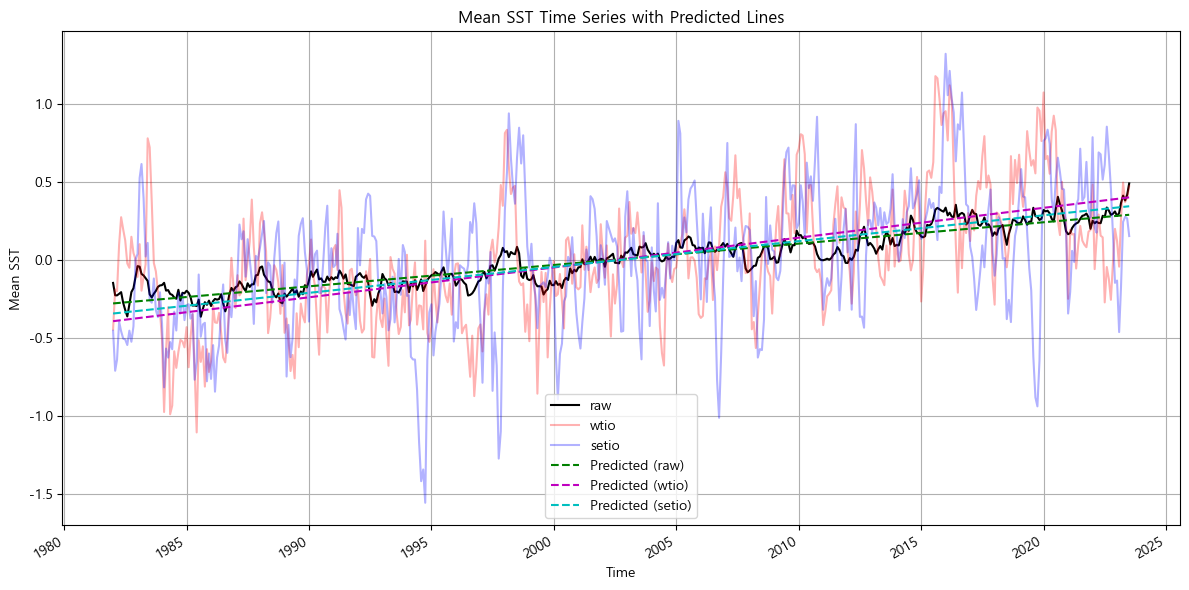

In [11]:
from scipy.stats import linregress

# 예측 모델을 학습하고 예측을 생성합니다 (여기에서는 간단한 선형 회귀 사용)
def train_and_predict_model(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    predicted_y = intercept + slope * x
    return predicted_y

# 예측 모델을 학습 및 예측합니다 (이 부분을 실제 모델 학습 및 예측으로 대체해야 합니다)
x = np.arange(len(sst_mean_total))
predicted_total = train_and_predict_model(x, sst_mean_total)
predicted_wtio = train_and_predict_model(x, sst_mean_wtio)
predicted_setio = train_and_predict_model(x, sst_mean_setio)

# 그래프를 그립니다.
fig, ax = plt.subplots(figsize=(12, 6))

sst_mean_total.plot.line(x='time', linestyle='-', color='k', label='raw', ax=ax)
sst_mean_wtio.plot.line(x='time', linestyle='-', color='r', alpha=0.3, label='wtio', ax=ax)
sst_mean_setio.plot.line(x='time', linestyle='-', color='b', alpha=0.3, label='setio', ax=ax)

# 예측 모델의 결과를 그래프에 추가합니다.
xr.DataArray(predicted_total, coords={'time': sst_mean_total.time}, dims=['time']).plot.line(x='time', linestyle='--', color='g', label='Predicted (raw)', ax=ax)
xr.DataArray(predicted_wtio, coords={'time': sst_mean_total.time}, dims=['time']).plot.line(x='time', linestyle='--', color='m', label='Predicted (wtio)', ax=ax)
xr.DataArray(predicted_setio, coords={'time': sst_mean_total.time}, dims=['time']).plot.line(x='time', linestyle='--', color='c', label='Predicted (setio)', ax=ax)

ax.set_title('Mean SST Time Series with Predicted Lines')
ax.set_xlabel('Time')
ax.set_ylabel('Mean SST')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


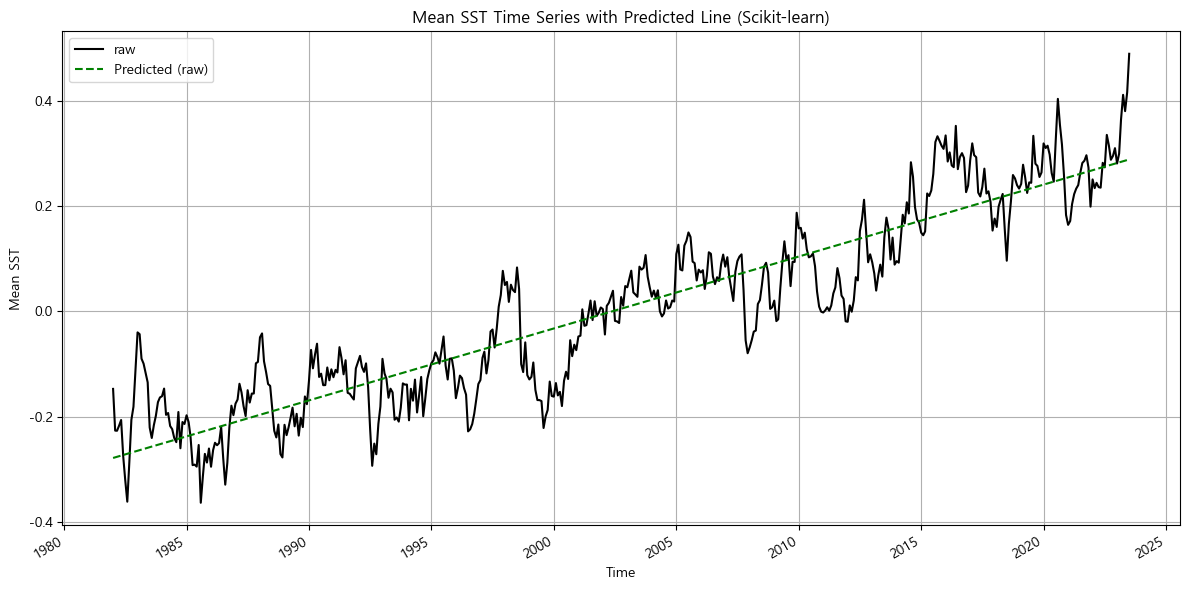

In [12]:
# LinearRegression 모델 초기화
model = LinearRegression()

# X: 시간, y: sst_mean_total (또는 다른 변수)를 사용하여 모델 학습
X = np.arange(len(sst_mean_total)).reshape(-1, 1)
y = sst_mean_total.values.reshape(-1, 1)
model.fit(X, y)

# 예측 생성
predicted_total = model.predict(X)

# 그래프를 그립니다.
fig, ax = plt.subplots(figsize=(12, 6))

sst_mean_total.plot.line(x='time', linestyle='-', color='k', label='raw', ax=ax)

# 예측 모델의 결과를 그래프에 추가합니다.
ax.plot(sst_mean_total.time, predicted_total, linestyle='--', color='g', label='Predicted (raw)')

ax.set_title('Mean SST Time Series with Predicted Line (Scikit-learn)')
ax.set_xlabel('Time')
ax.set_ylabel('Mean SST')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

-------------------------------------------------------------

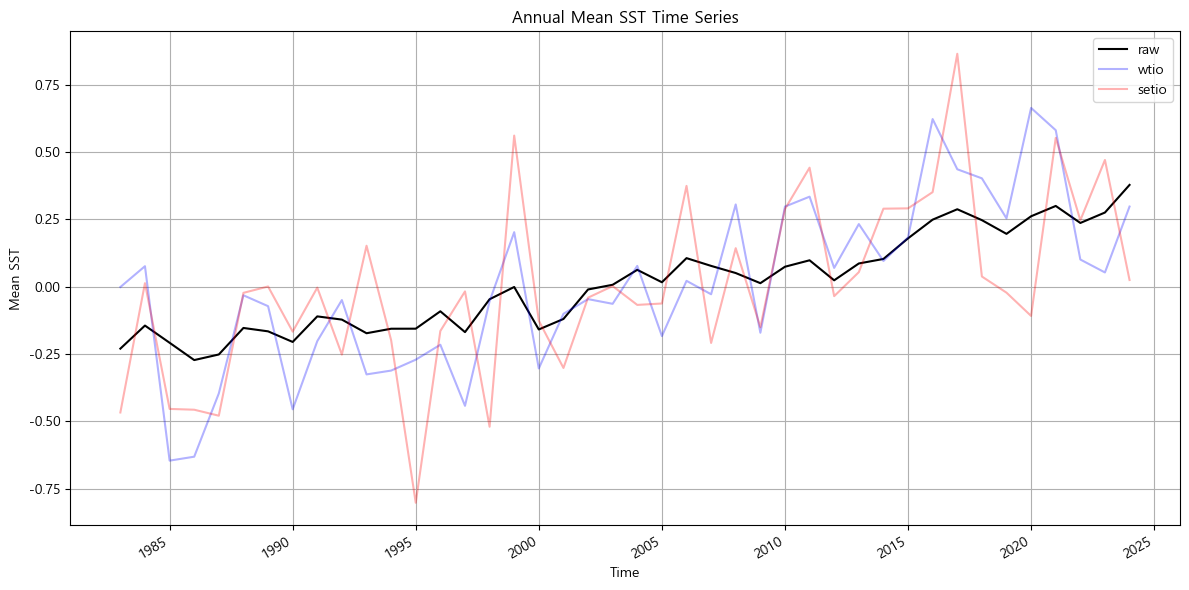

In [13]:
# SST 평균화
sst_mean = sst['sst'].mean(dim=['lat', 'lon'])

# 선택한 위도 및 경도 범위 내에서의 SST를 추출합니다.
# wtio
min_lat_wtio, max_lat_wtio, min_lon_wtio, max_lon_wtio = -10, 10, 50, 70
sst_wtio = sst['sst'].sel(lat=slice(min_lat_wtio, max_lat_wtio), lon=slice(min_lon_wtio, max_lon_wtio))

# wtio 범위 내에서 SST를 평균화합니다.
wtio_mean = sst_wtio.mean(dim=['lat', 'lon'])

# 선택한 위도 및 경도 범위 내에서의 SST를 추출합니다.
# setio
min_lat_setio, max_lat_setio, min_lon_setio, max_lon_setio = -10, 0, 90, 110
sst_setio = sst['sst'].sel(lat=slice(min_lat_setio, max_lat_setio), lon=slice(min_lon_setio, max_lon_setio))

# setio 범위 내에서 SST를 평균화합니다.
setio_mean = sst_setio.mean(dim=['lat', 'lon'])

# 연간 평균 그래프를 생성합니다.
fig, ax = plt.subplots(figsize=(12, 6))

# 세 가지 시계열 그래프를 하나의 그래프에 그립니다.
sst_mean.resample(time='Y').mean(dim='time').plot.line(x='time', linestyle='-', color='k', label='raw', ax=ax)
wtio_mean.resample(time='Y').mean(dim='time').plot.line(x='time', linestyle='-', color='b', label='wtio', ax=ax, alpha=0.3)
setio_mean.resample(time='Y').mean(dim='time').plot.line(x='time', linestyle='-', color='r', label='setio', ax=ax, alpha=0.3)

ax.set_title('Annual Mean SST Time Series')
ax.set_xlabel('Time')
ax.set_ylabel('Mean SST')
ax.legend()
ax.grid(True)

plt.tight_layout()  # subplot 간 간격을 조절
plt.show()


## 특정시간 sst 그래프

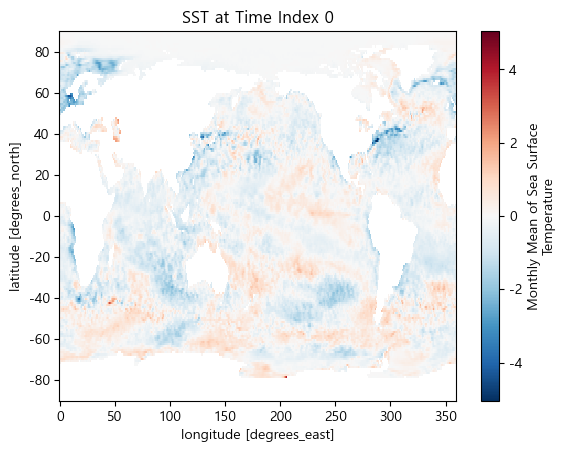

In [14]:
# 특정 시간에 대한 SST를 선택하고 그에 해당하는 위도와 경도에 대한 그래프를 플롯합니다.
time_index = 0  # 시간 인덱스를 선택합니다.

specific_time = sst['sst'].isel(time=time_index)
specific_time.plot()

plt.title(f'SST at Time Index {time_index}')
plt.show()

# PRECIP

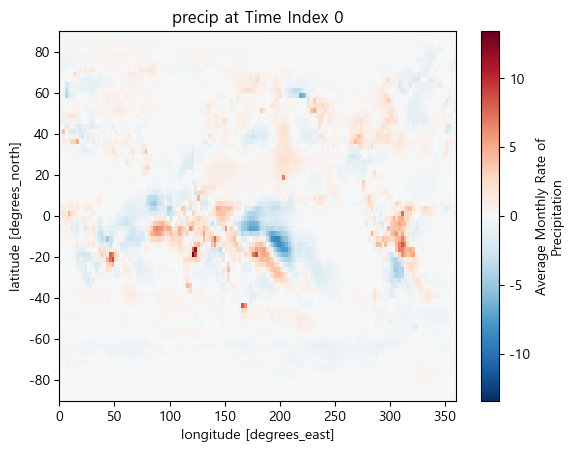

In [15]:
time_index = 0  # 시간 인덱스를 선택합니다.

specific_time = precip['precip'].isel(time=time_index)
specific_time.plot()

plt.title(f'precip at Time Index {time_index}')
plt.show()

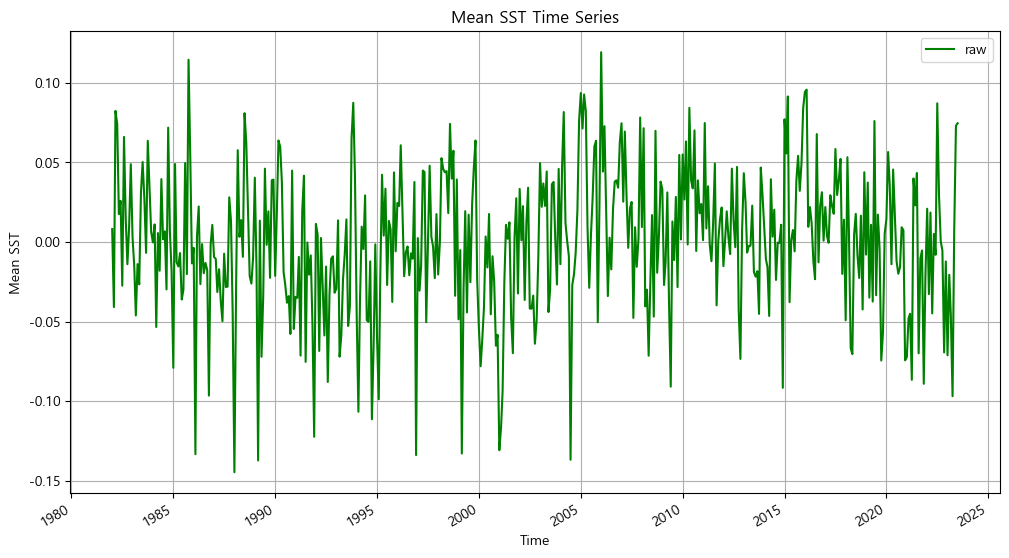

In [16]:
# precip : 전체 지역 -> 강수량의 경우 지역마다 편차가 심하기 때문에, 전체 값을 보는 것은 의미가 없다고 생각
precip_mean = precip['precip'].mean(dim=['lat', 'lon'])

# precip 평균화된 시계열 그래프를 생성합니다.
fig = plt.figure(figsize=(12, 6))
precip_mean.plot.line(x='time', linestyle='-', c='g', label='raw')

plt.title(f'Mean SST Time Series')
plt.xlabel('Time')
plt.ylabel('Mean SST')
plt.legend()
plt.grid(True)
plt.show()

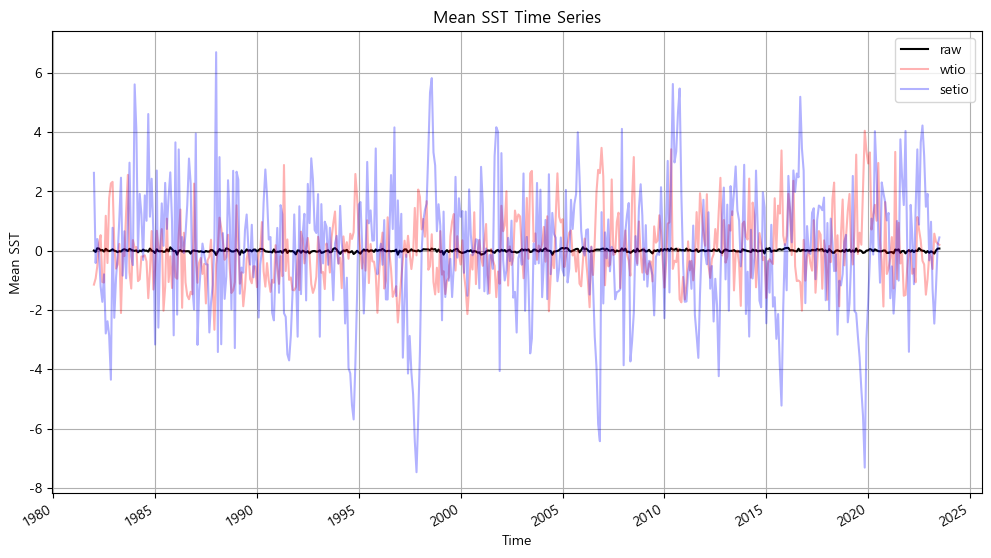

In [17]:
# 지역별 precip 편차
# precip 전체 평균
precip_mean_total = precip['precip'].mean(dim=['lat', 'lon'])

# wtio
# 선택한 위도 및 경도 범위 내에서의 precip를 추출합니다.
min_lat_wtio, max_lat_wtio, min_lon_wtio, max_lon_wtio = -10, 10, 50, 70
precip_wtio = precip['precip'].sel(lat=slice(min_lat_wtio, max_lat_wtio), lon=slice(min_lon_wtio, max_lon_wtio))

# wtio 범위 내에서 precip를 평균화합니다.
precip_mean_wtio = precip_wtio.mean(dim=['lat', 'lon'])

# setio
# 선택한 위도 및 경도 범위 내에서의 precip를 추출합니다.
min_lat_setio, max_lat_setio, min_lon_setio, max_lon_setio = -10, 0, 90, 110
precip_setio = precip['precip'].sel(lat=slice(min_lat_setio, max_lat_setio), lon=slice(min_lon_setio, max_lon_setio))

# setio 범위 내에서 precip를 평균화합니다.
precip_mean_setio = precip_setio.mean(dim=['lat', 'lon'])

# 그래프를 하나의 이미지에 그립니다.
fig, ax = plt.subplots(figsize=(12, 6))

# 세 가지 시계열 그래프를 하나의 그래프에 그립니다.
precip_mean_total.plot.line(x='time', linestyle='-', color='k', label='raw', ax=ax)
precip_mean_wtio.plot.line(x='time', linestyle='-', color='r', alpha=0.3, label='wtio', ax=ax)
precip_mean_setio.plot.line(x='time', linestyle='-', color='b', alpha=0.3, label='setio', ax=ax)

ax.set_title('Mean SST Time Series')
ax.set_xlabel('Time')
ax.set_ylabel('Mean SST')
ax.legend()
ax.grid(True)
plt.show()

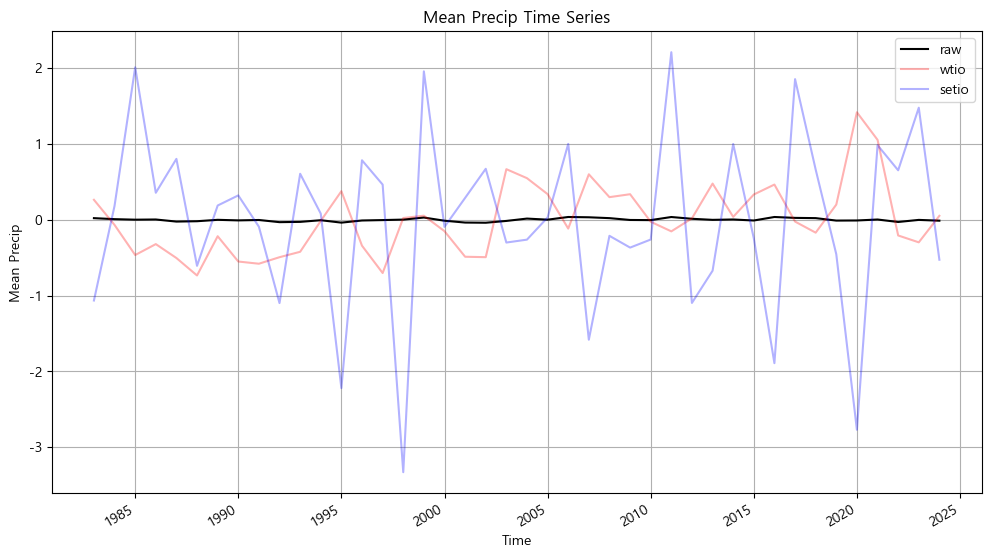

In [18]:
# 지역별 precip 편차
# precip 전체 평균
precip_mean_total = precip['precip'].mean(dim=['lat', 'lon'])

# wtio
# 선택한 위도 및 경도 범위 내에서의 precip를 추출합니다.
min_lat_wtio, max_lat_wtio, min_lon_wtio, max_lon_wtio = -10, 10, 50, 70
precip_wtio = precip['precip'].sel(lat=slice(min_lat_wtio, max_lat_wtio), lon=slice(min_lon_wtio, max_lon_wtio))

# wtio 범위 내에서 precip를 평균화합니다.
precip_mean_wtio = precip_wtio.mean(dim=['lat', 'lon'])

# setio
# 선택한 위도 및 경도 범위 내에서의 precip를 추출합니다.
min_lat_setio, max_lat_setio, min_lon_setio, max_lon_setio = -10, 0, 90, 110
precip_setio = precip['precip'].sel(lat=slice(min_lat_setio, max_lat_setio), lon=slice(min_lon_setio, max_lon_setio))

# setio 범위 내에서 precip를 평균화합니다.
precip_mean_setio = precip_setio.mean(dim=['lat', 'lon'])

# 그래프를 하나의 이미지에 그립니다.
fig, ax = plt.subplots(figsize=(12, 6))

# 세 가지 시계열 그래프를 하나의 그래프에 그립니다.
precip_mean_total.resample(time='Y').mean(dim='time').plot.line(x='time', linestyle='-', color='k', label='raw', ax=ax)
precip_mean_wtio.resample(time='Y').mean(dim='time').plot.line(x='time', linestyle='-', color='r', alpha=0.3, label='wtio', ax=ax)
precip_mean_setio.resample(time='Y').mean(dim='time').plot.line(x='time', linestyle='-', color='b', alpha=0.3, label='setio', ax=ax)

ax.set_title('Mean Precip Time Series')
ax.set_xlabel('Time')
ax.set_ylabel('Mean Precip')
ax.legend()
ax.grid(True)
plt.show()

# IOD

## 기간 내 IOD 그래프

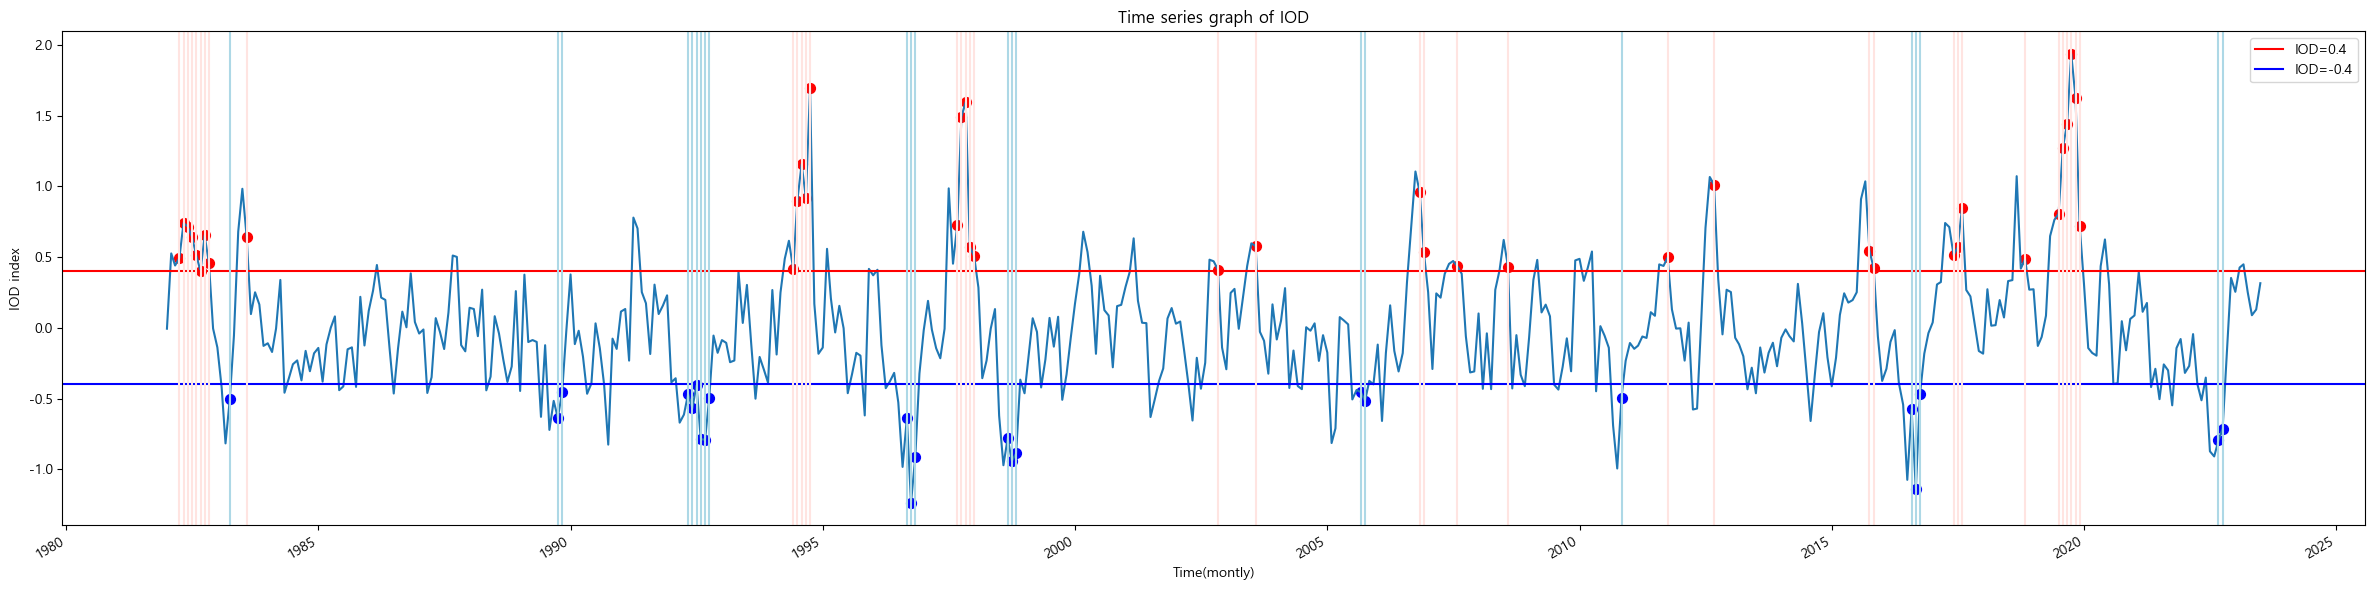

In [21]:
iod = xr.open_dataset(official_data_path+'iod.nc')

# event 시각화
iod=iod.iod
iod_values = iod.values.flatten()

iod.plot(aspect=4, size=6) #size 조절

#.figsize = (aspect * size, size)
plt.tight_layout()
plt.xlabel("Time(montly)")  # x축 이름 설정
plt.ylabel("IOD index")  # y축 이름 설정

plt.title("Time series graph of IOD")

# IOD 값이 0.4와 -0.4인 기준선 추가
plt.axhline(0.4, color='r', linestyle='-', label='IOD=0.4')
plt.axhline(-0.4, color='b', linestyle='-', label='IOD=-0.4')

plt.legend()  # 범례 추가

# pos : IOD 값이 연속으로 3개월 이상 0.4 이상인 시간 식별
consecutive_months = 0
for i in range(len(iod)):
    if iod[i] >= 0.4:
        consecutive_months += 1
        if consecutive_months >= 3:
            # 연속 3개월 이상 0.4 이상인 시간에 세로선 추가
            plt.axvline(iod.time.values[i], color='mistyrose', linestyle='-', label='3+ consecutive months')
            #plt.fill_between(iod.time.values[i - 2:i + 1], iod[i - 2:i + 1], color='lightcolal')

            # IOD 값이 0.4 이상인 시간에 동그라미로 표시
            plt.scatter(iod.time.values[i], iod[i], color='r', marker='o', s=50, label='IOD>=0.4')
    else:
        consecutive_months = 0

# neg : IOD 값이 연속으로 3개월 이상 -0.4 이하인 시간 식별
consecutive_months = 0
for i in range(len(iod)):
    if iod[i] <= -0.4:
        consecutive_months += 1
        if consecutive_months >= 3:
            # 연속 3개월 이상 -0.4 이하인 시간에 세로선 추가
            plt.axvline(iod.time.values[i], color='lightblue', linestyle='-', label='3+ consecutive months')
            # IOD 값이 -0.4 이하인 시간에 동그라미로 표시
            plt.scatter(iod.time.values[i], iod[i], color='b', marker='o', s=50, label='IOD>=0.4')
    else:
        consecutive_months = 0

plt.savefig(image_path+'graph/iod_event.png', dpi=300, bbox_inches='tight')

plt.show()

## pos/neg event 구분

### event dates

In [22]:
iod = xr.open_dataset(official_data_path+'iod.nc')

iod=iod.iod
iod_values = iod.values.flatten()

positive_event_dates = []
negative_event_dates = []

consecutive_months_positive = 0
consecutive_months_negative = 0

for i in range(len(iod)):
    if iod_values[i] >= 0.4:
        consecutive_months_positive += 1
        if consecutive_months_positive >= 3:
            t = np.datetime_as_string(iod.time.values[i], unit='D')
            positive_event_dates.append(t)
    else:
        consecutive_months_positive = 0

    if iod_values[i] <= -0.4:
        consecutive_months_negative += 1
        if consecutive_months_negative >= 3:
            t = np.datetime_as_string(iod.time.values[i], unit='D')
            negative_event_dates.append(t)
    else:
        consecutive_months_negative = 0

print("Positive Event Dates (IOD >= 0.4):\n", positive_event_dates, '\n')
print("Negative Event Dates (IOD <= -0.4):\n", negative_event_dates)


Positive Event Dates (IOD >= 0.4):
 ['1982-04-01', '1982-05-01', '1982-06-01', '1982-07-01', '1982-08-01', '1982-09-01', '1982-10-01', '1982-11-01', '1983-08-01', '1994-06-01', '1994-07-01', '1994-08-01', '1994-09-01', '1994-10-01', '1997-09-01', '1997-10-01', '1997-11-01', '1997-12-01', '1998-01-01', '2002-11-01', '2003-08-01', '2006-11-01', '2006-12-01', '2007-08-01', '2008-08-01', '2011-10-01', '2012-09-01', '2015-10-01', '2015-11-01', '2017-06-01', '2017-07-01', '2017-08-01', '2018-11-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'] 

Negative Event Dates (IOD <= -0.4):
 ['1983-04-01', '1989-10-01', '1989-11-01', '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01', '1992-09-01', '1992-10-01', '1996-09-01', '1996-10-01', '1996-11-01', '1998-09-01', '1998-10-01', '1998-11-01', '2005-09-01', '2005-10-01', '2010-11-01', '2016-08-01', '2016-09-01', '2016-10-01', '2022-09-01', '2022-10-01']


### event + consecutive months

In [23]:
iod = xr.open_dataset(official_data_path+'iod.nc')
iod=iod.iod
iod_values = iod.values.flatten()

positive_event_dates = []  
negative_event_dates = []
positive_consecutive = []
negative_consecutive = []

consecutive_months_positive = 0
consecutive_months_negative = 0

iod_values = iod.values.flatten()

for i in range(len(iod)):
    if iod_values[i] >= 0.4:
        consecutive_months_positive += 1
        if consecutive_months_positive >= 3:
            t = np.datetime_as_string(iod.time.values[i], unit='D')
            positive_event_dates.append(t)
            positive_consecutive.append(consecutive_months_positive)
            pos_df = pd.DataFrame({'pos_event':positive_event_dates , 'consecutive':positive_consecutive})
    else:
        consecutive_months_positive = 0

    if iod_values[i] <= -0.4:
        consecutive_months_negative += 1
        if consecutive_months_negative >= 3:
            t = np.datetime_as_string(iod.time.values[i], unit='D')
            negative_event_dates.append(t)
            negative_consecutive.append(consecutive_months_negative)
            neg_df = pd.DataFrame({'neg_event':negative_event_dates , 'consecutive':negative_consecutive})
    else:
        consecutive_months_negative = 0

Text(0.5, 1.0, 'negative IOD event consecutive months')

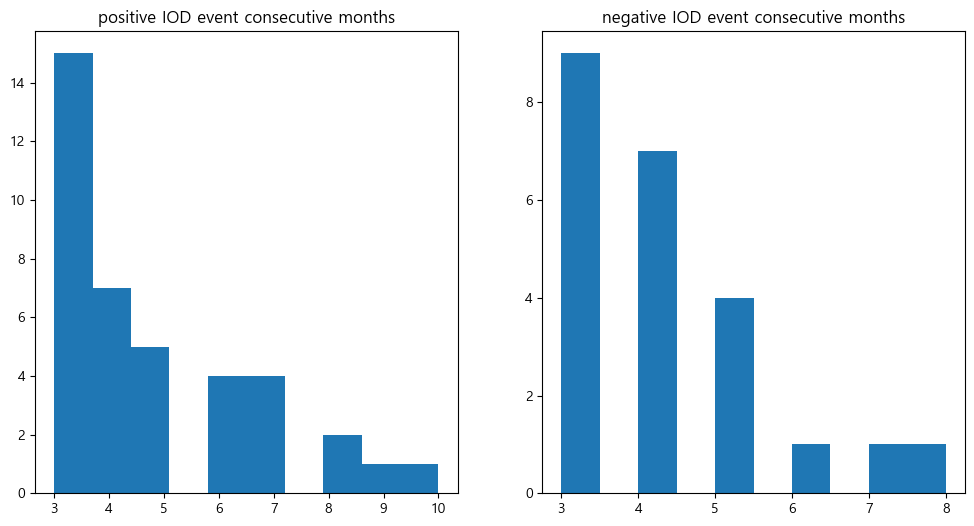

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(pos_df['consecutive'])
ax1.set_title('positive IOD event consecutive months')

ax2.hist(neg_df['consecutive'])
ax2.set_title('negative IOD event consecutive months')

## iod event 별 평균 SST, Precip

### positive event

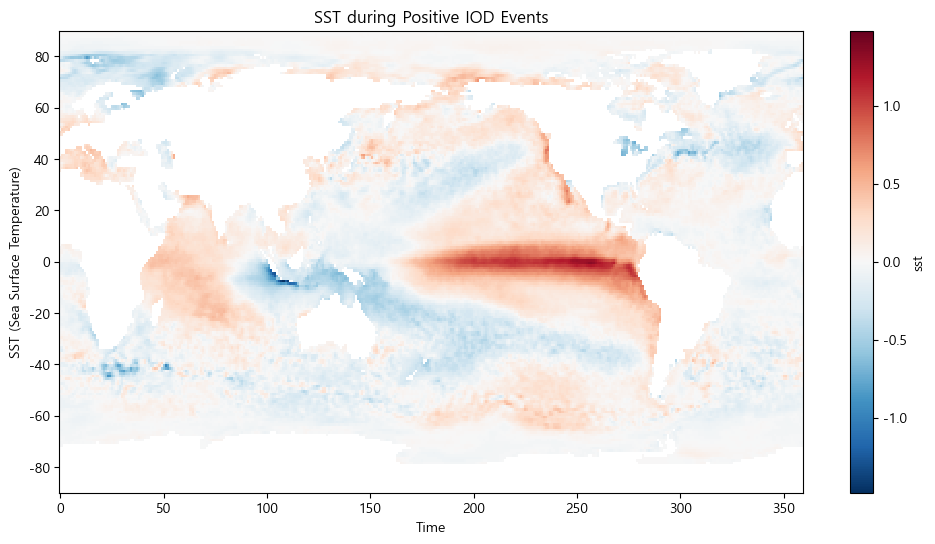

In [25]:
# sst
sst_positive_event = sst.sel(time=positive_event_dates).mean(dim='time')

plt.figure(figsize=(12, 6))
sst_positive_event.sst.plot(label='Positive IOD Event')

plt.xlabel('Time')
plt.ylabel('SST (Sea Surface Temperature)')
plt.title('SST during Positive IOD Events')
plt.show()

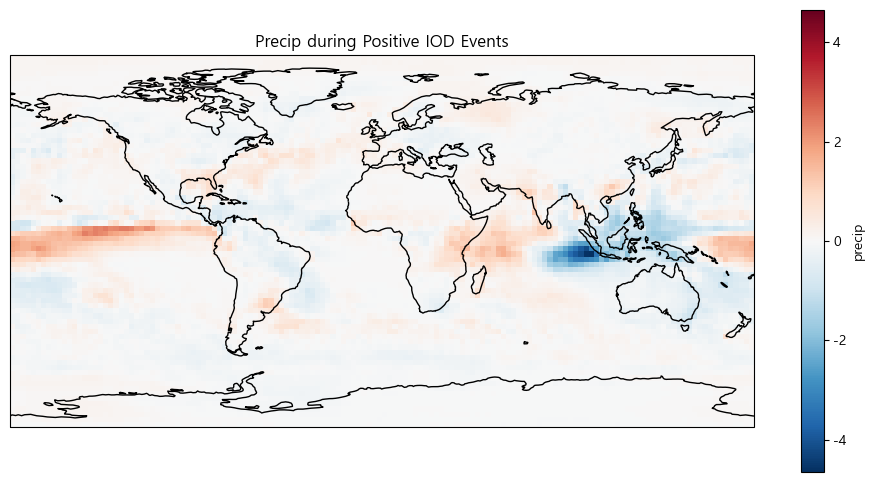

In [26]:
# precip
precip_positive_event = precip.sel(time=positive_event_dates).mean(dim='time')

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE) # 해안선 그리기
precip_positive_event.precip.plot(label='Positive IOD Event')

plt.xlabel('Time')
plt.ylabel('Precip')
plt.title('Precip during Positive IOD Events')

plt.show()

### negative event

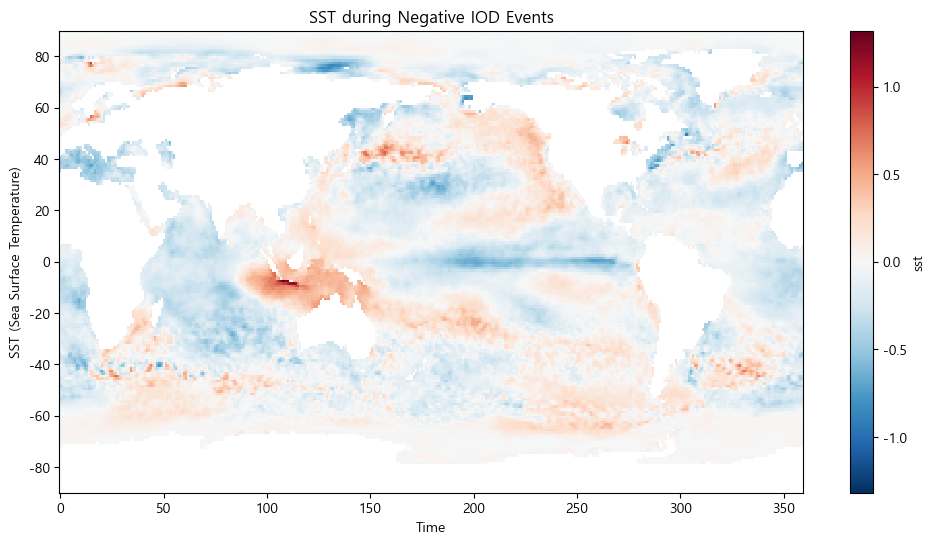

In [27]:
# sst
sst_negative_event = sst.sel(time=negative_event_dates).mean(dim='time')

plt.figure(figsize=(12, 6))
sst_negative_event.sst.plot(label='Negative IOD Event')

plt.xlabel('Time')
plt.ylabel('SST (Sea Surface Temperature)')
plt.title('SST during Negative IOD Events')
plt.show()

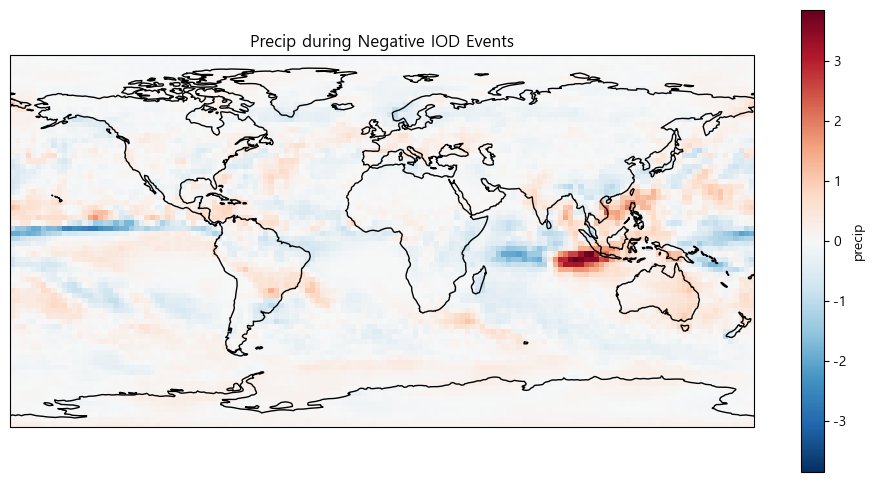

In [28]:
# precip
precip_negative_event = precip.sel(time=negative_event_dates).mean(dim='time')

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE) # 해안선 그리기
precip_negative_event.precip.plot(label='Negative IOD Event')

plt.xlabel('Time')
plt.ylabel('Precip')
plt.title('Precip during Negative IOD Events')

plt.show()

### neutral event

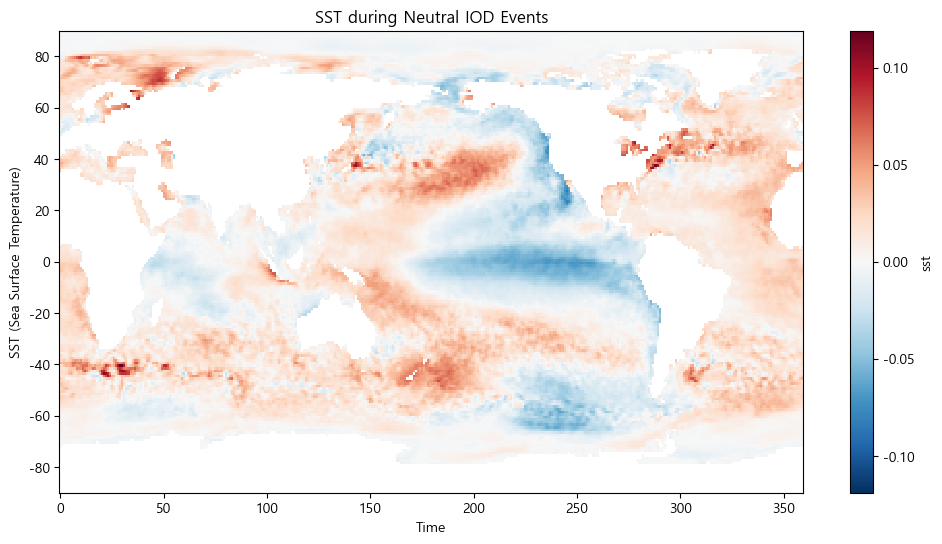

In [29]:
# sst
all_event_dates = positive_event_dates + negative_event_dates

# 전체 날짜에서 이벤트 날짜를 제외한 날짜 리스트 생성
total_time = np.datetime_as_string(sst.time.values, unit='D')
non_event_dates = [date for date in total_time if date not in all_event_dates]

sst_netral_event = sst.sel(time=non_event_dates).mean(dim='time')

plt.figure(figsize=(12, 6))
sst_netral_event.sst.plot(label='Neutral IOD Event')

plt.xlabel('Time')
plt.ylabel('SST (Sea Surface Temperature)')
plt.title('SST during Neutral IOD Events')
plt.show()

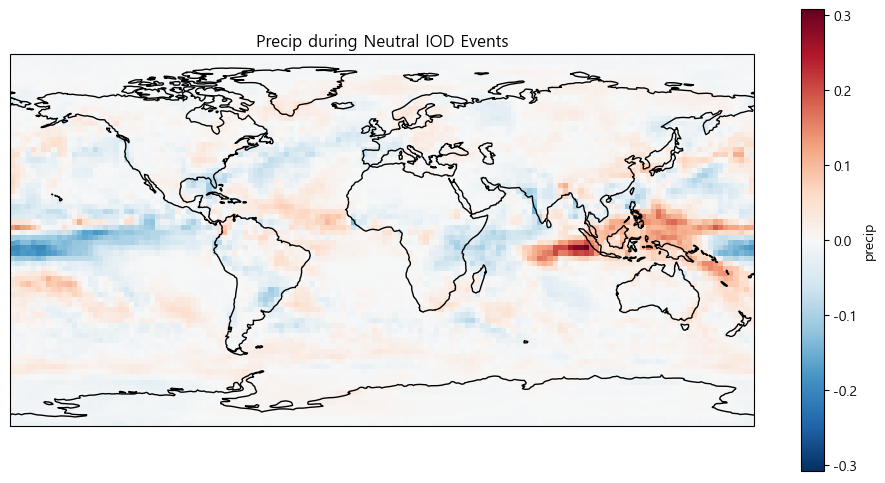

In [30]:
# precip
precip_neutral_event = precip.sel(time=non_event_dates).mean(dim='time')

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE) # 해안선 그리기
precip_neutral_event.precip.plot(label='Neutral IOD Event')

plt.xlabel('Time')
plt.ylabel('Precip')
plt.title('Precip during Neutral IOD Events')

plt.show()

## iod event 지속기간(최소3, 최대8/10) 별 SST, Precip

### positive event : 3개월
3개월 : 총 15개 -> 평균

In [31]:
pos_df[pos_df['consecutive']==3].shape

(15, 2)

In [32]:
pos_3 = pos_df[pos_df['consecutive']==3]['pos_event'].tolist()

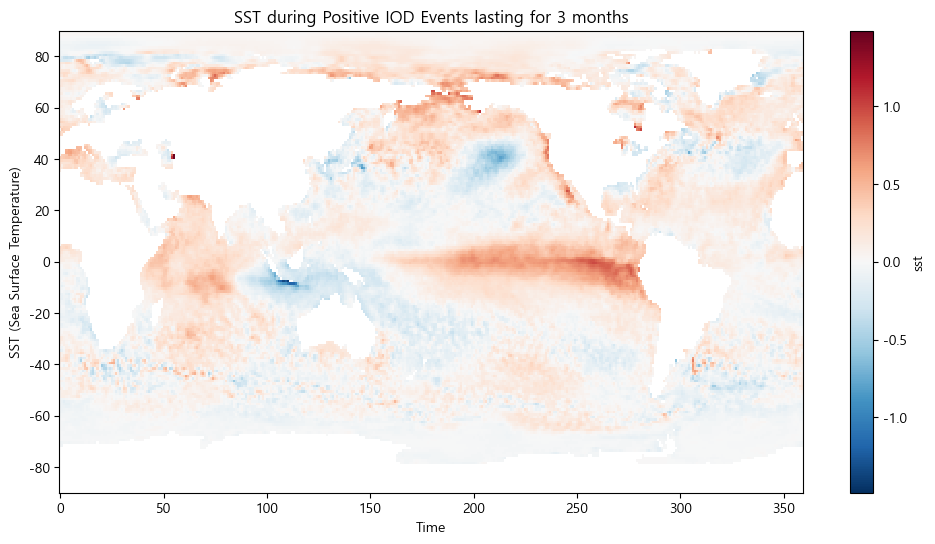

In [33]:
# sst
sst_positive_event = sst.sel(time=pos_3).mean(dim='time')

plt.figure(figsize=(12, 6))
sst_positive_event.sst.plot(label='Positive IOD Event')

plt.xlabel('Time')
plt.ylabel('SST (Sea Surface Temperature)')
plt.title('SST during Positive IOD Events lasting for 3 months')
plt.show()

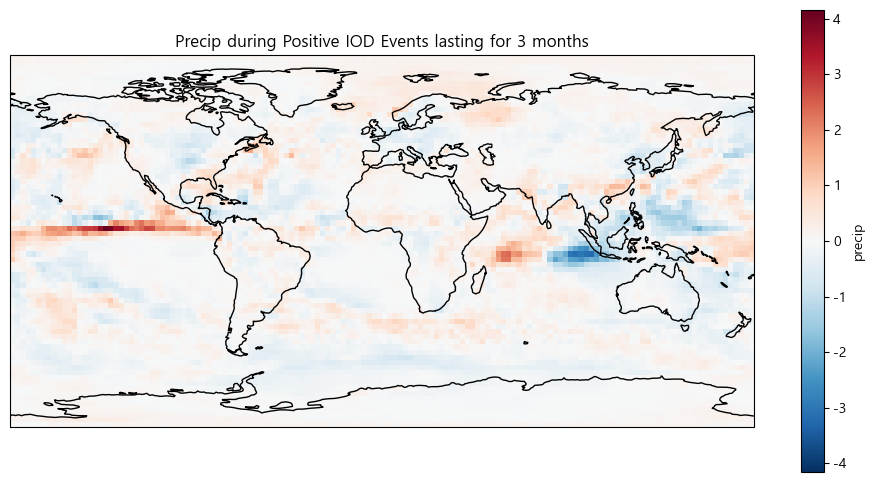

In [34]:
# precip
precip_positive_event = precip.sel(time=pos_3).mean(dim='time')

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE) # 해안선 그리기
precip_positive_event.precip.plot(label='Positive IOD Event')

plt.xlabel('Time')
plt.ylabel('Precip (Sea Surface Temperature)')
plt.title('Precip during Positive IOD Events lasting for 3 months')

plt.show()

### positive event : 10개월
10개월 : 1개

In [35]:
pos_df[pos_df['consecutive']==10].shape

(1, 2)

In [36]:
pos_10 = pos_df[pos_df['consecutive']==10]['pos_event'].tolist()
pos_10 # ['1982-11-01']

['1982-11-01']

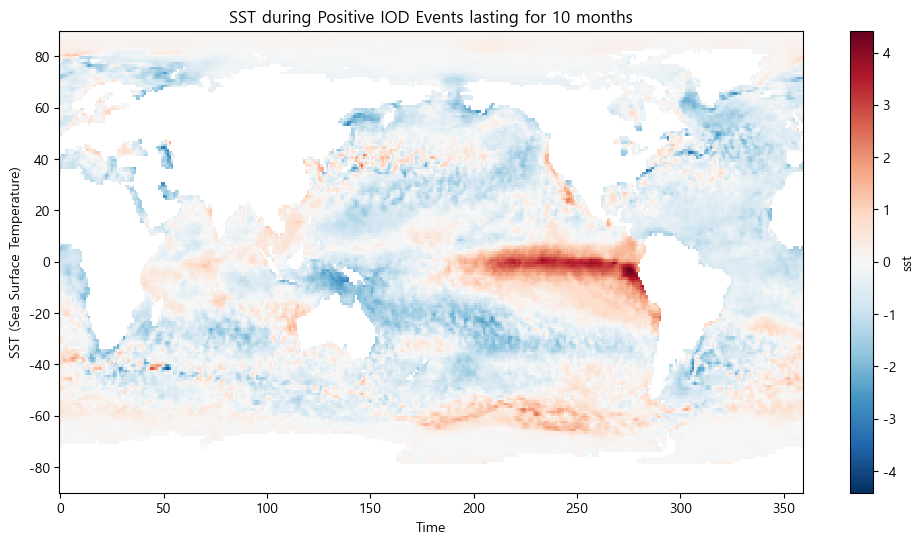

In [37]:
# sst
sst_positive_event = sst.sel(time=pos_10).mean(dim='time')

plt.figure(figsize=(12, 6))
sst_positive_event.sst.plot(label='Positive IOD Event')

plt.xlabel('Time')
plt.ylabel('SST (Sea Surface Temperature)')
plt.title('SST during Positive IOD Events lasting for 10 months')
plt.show()

In [38]:
pos_10_2 = ['1982-04-01'] # 3개월 차 sst 확인

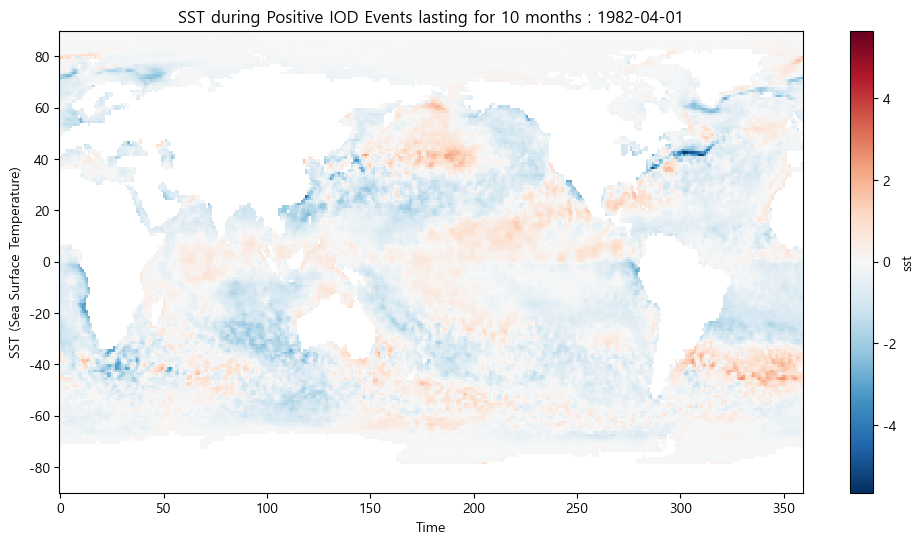

In [39]:
# sst (3개월차)
sst_positive_event = sst.sel(time=pos_10_2).mean(dim='time')

plt.figure(figsize=(12, 6))
sst_positive_event.sst.plot(label='Positive IOD Event')

plt.xlabel('Time')
plt.ylabel('SST (Sea Surface Temperature)')
plt.title('SST during Positive IOD Events lasting for 10 months : 1982-04-01')
plt.show()

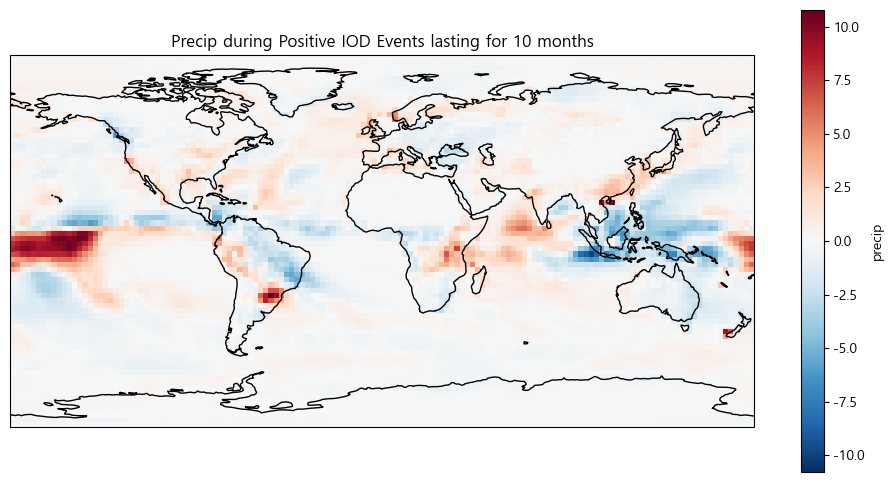

In [40]:
# precip
precip_positive_event = precip.sel(time=pos_10).mean(dim='time')

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE) # 해안선 그리기
precip_positive_event.precip.plot(label='Positive IOD Event')

plt.xlabel('Time')
plt.ylabel('Precip (Sea Surface Temperature)')
plt.title('Precip during Positive IOD Events lasting for 10 months')

plt.show()

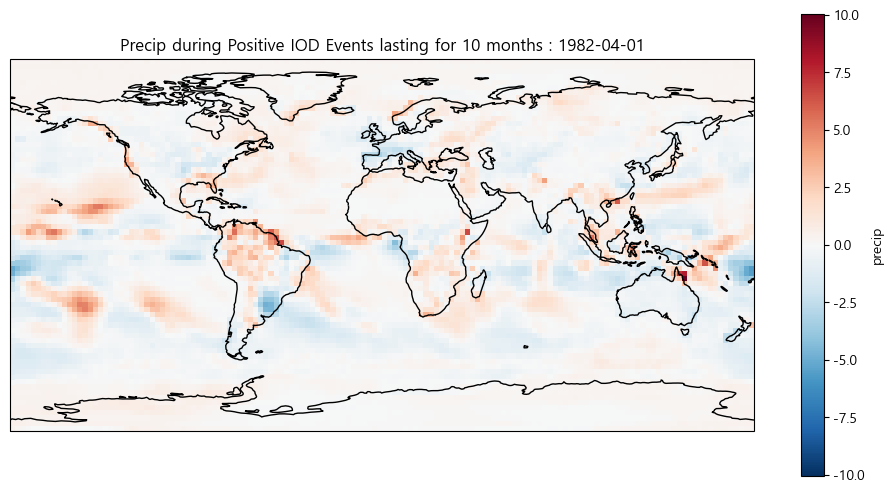

In [41]:
# precip (3개월차)
precip_positive_event = precip.sel(time=pos_10_2).mean(dim='time')

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE) # 해안선 그리기
precip_positive_event.precip.plot(label='Positive IOD Event')

plt.xlabel('Time')
plt.ylabel('Precip (Sea Surface Temperature)')
plt.title('Precip during Positive IOD Events lasting for 10 months : 1982-04-01')

plt.show()

### negative event : 3개월

In [42]:
neg_3 = neg_df[neg_df['consecutive']==3]['neg_event'].tolist()

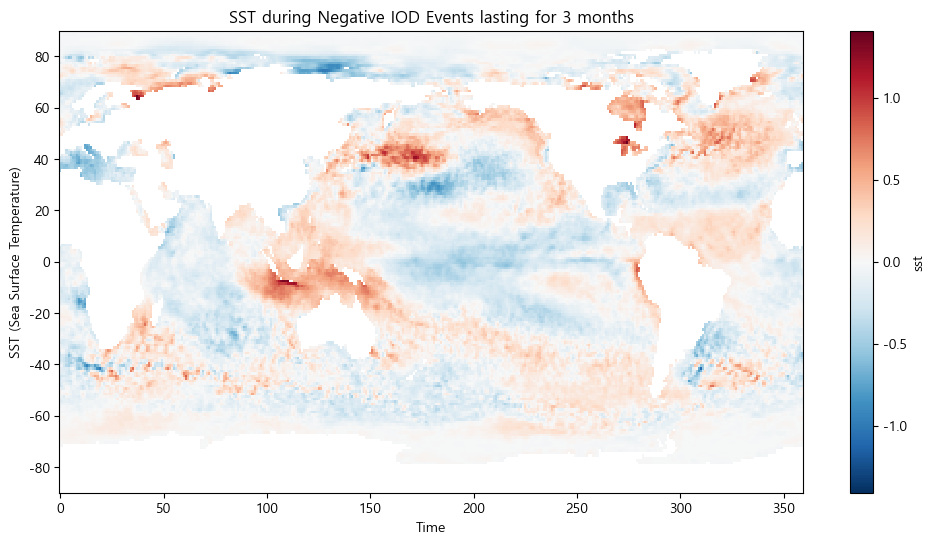

In [43]:
# sst
sst_negative_event = sst.sel(time=neg_3).mean(dim='time')

plt.figure(figsize=(12, 6))
sst_negative_event.sst.plot(label='Negative IOD Event')

plt.xlabel('Time')
plt.ylabel('SST (Sea Surface Temperature)')
plt.title('SST during Negative IOD Events lasting for 3 months')
plt.show()

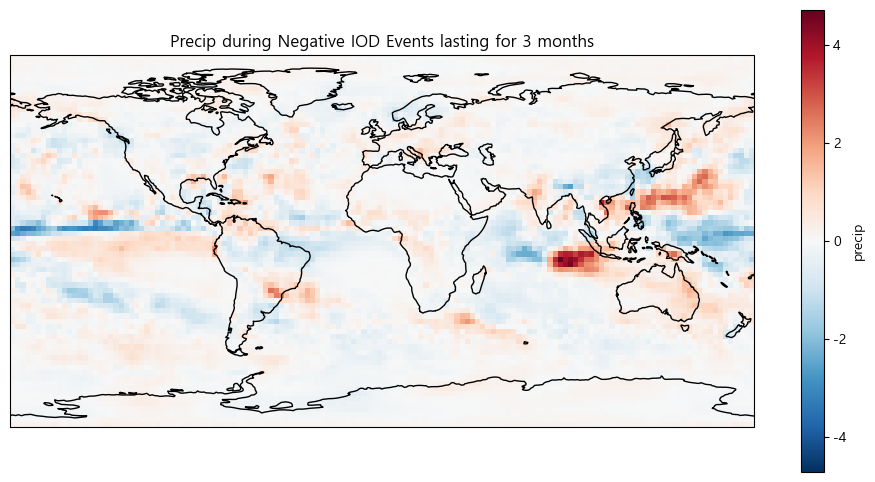

In [44]:
# precip
precip_negative_event = precip.sel(time=neg_3).mean(dim='time')

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE) # 해안선 그리기
precip_negative_event.precip.plot(label='Negative IOD Event')

plt.xlabel('Time')
plt.ylabel('Precip (Sea Surface Temperature)')
plt.title('Precip during Negative IOD Events lasting for 3 months')

plt.show()

### negative event : 8개월

In [45]:
neg_8 = neg_df[neg_df['consecutive']==8]['neg_event'].tolist()

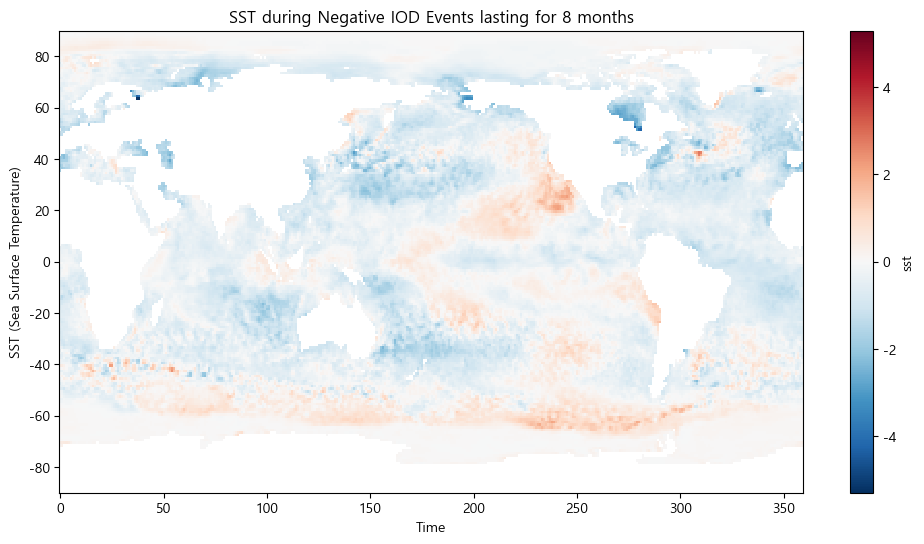

In [46]:
# sst
sst_negative_event = sst.sel(time=neg_8).mean(dim='time')

plt.figure(figsize=(12, 6))
sst_negative_event.sst.plot(label='Negative IOD Event')

plt.xlabel('Time')
plt.ylabel('SST (Sea Surface Temperature)')
plt.title('SST during Negative IOD Events lasting for 8 months')
plt.show()

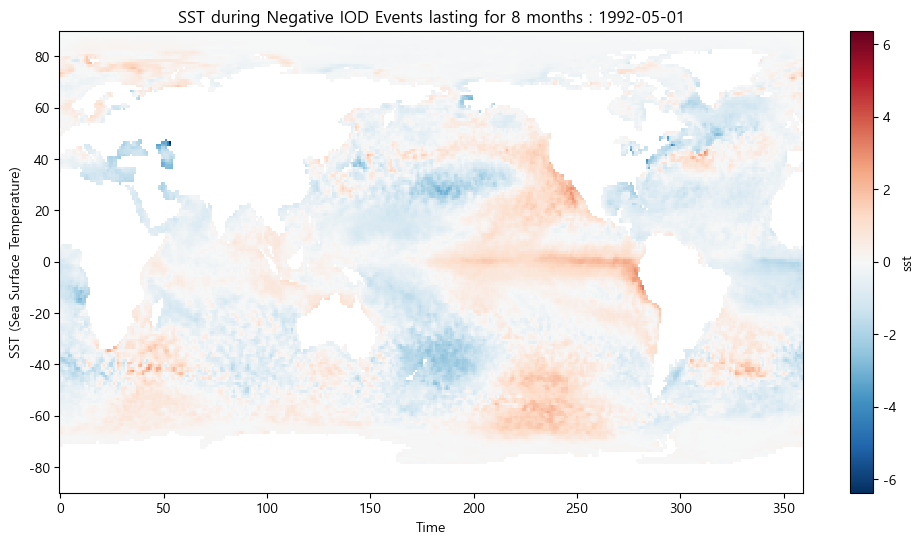

In [47]:
neg_8_2 = ['1992-05-01'] 

# sst
sst_negative_event = sst.sel(time=neg_8_2).mean(dim='time')

plt.figure(figsize=(12, 6))
sst_negative_event.sst.plot(label='Negative IOD Event')

plt.xlabel('Time')
plt.ylabel('SST (Sea Surface Temperature)')
plt.title('SST during Negative IOD Events lasting for 8 months : 1992-05-01')
plt.show()

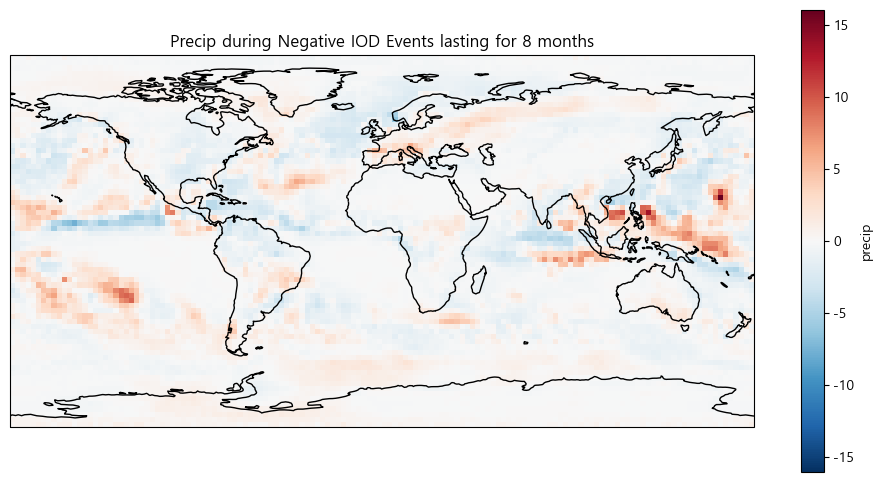

In [48]:
# precip
precip_negative_event = precip.sel(time=neg_8).mean(dim='time')

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE) # 해안선 그리기
precip_negative_event.precip.plot(label='Negative IOD Event')

plt.xlabel('Time')
plt.ylabel('Precip (Sea Surface Temperature)')
plt.title('Precip during Negative IOD Events lasting for 8 months')

plt.show()

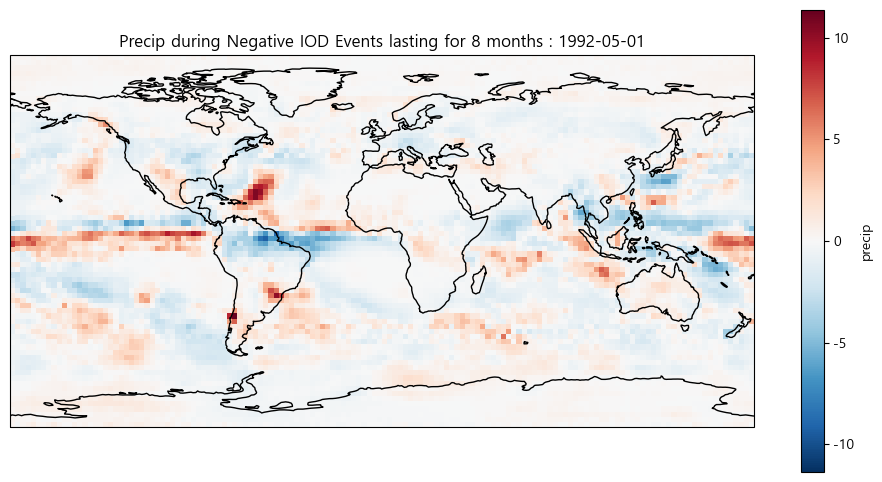

In [49]:
# precip
precip_negative_event = precip.sel(time=neg_8_2).mean(dim='time')

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE) # 해안선 그리기
precip_negative_event.precip.plot(label='Negative IOD Event')

plt.xlabel('Time')
plt.ylabel('Precip (Sea Surface Temperature)')
plt.title('Precip during Negative IOD Events lasting for 8 months : 1992-05-01')

plt.show()

## iod event 내 특정 일자 SST 시각화
iod가 가장 높은 날, 가장 낮은 날만 뽑아서 시각화 진행

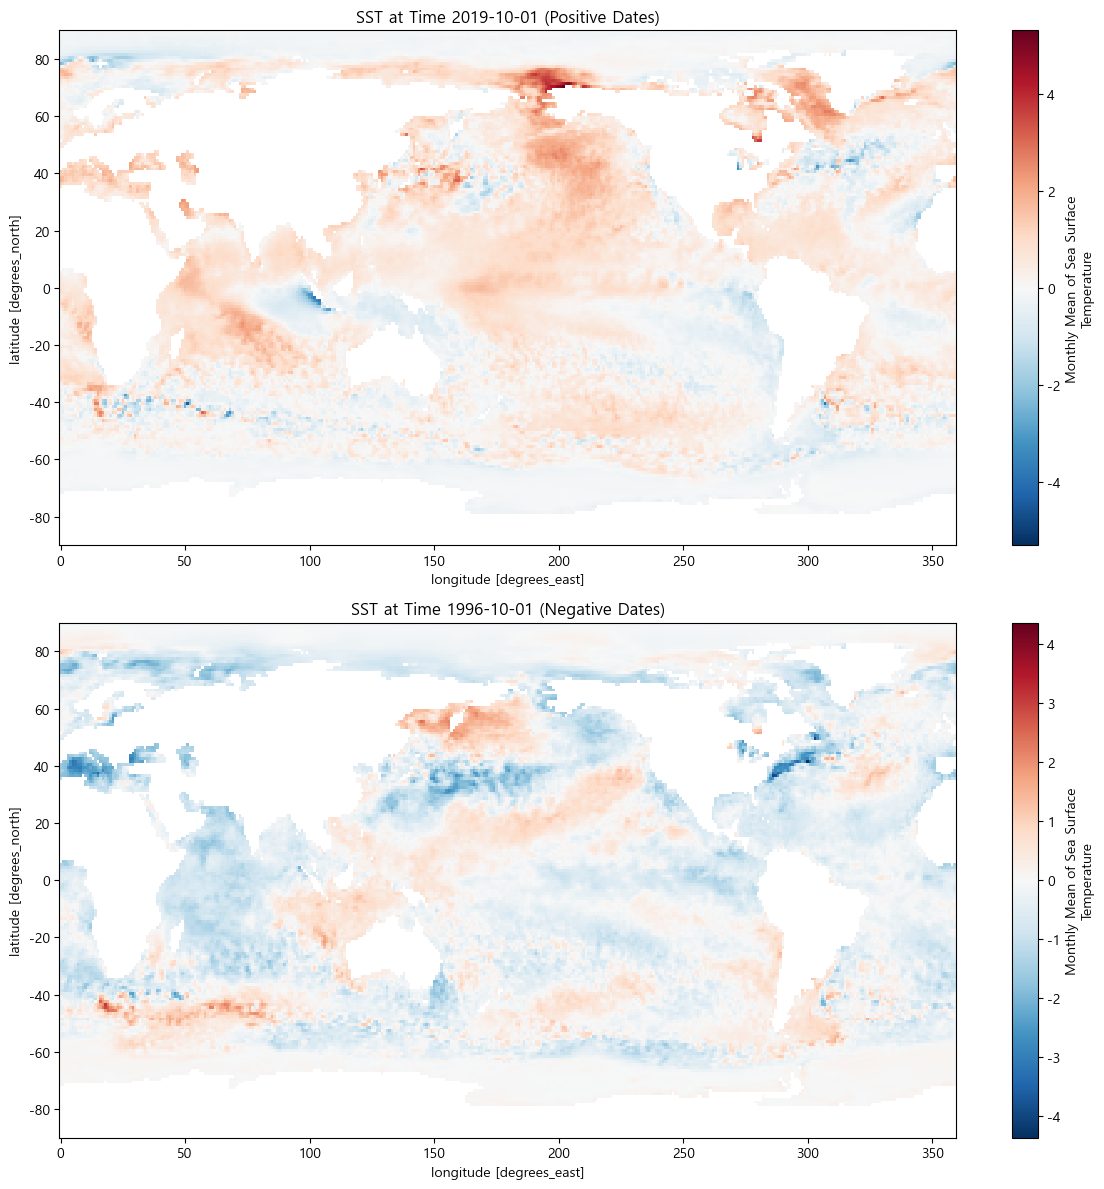

In [50]:
# positive_dates 중에서 원하는 시간에 대한 SST 데이터를 가져옵니다.
specific_date_positive = '2019-10-01'
specific_time_positive = sst['sst'].sel(time=specific_date_positive)

# negative_dates 중에서 원하는 시간에 대한 SST 데이터를 가져옵니다.
specific_date_negative = '1996-10-01'
specific_time_negative = sst['sst'].sel(time=specific_date_negative)

# 두 그래프를 하나의 이미지에 그립니다.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

specific_time_positive.plot(ax=ax1)
ax1.set_title(f'SST at Time {specific_date_positive} (Positive Dates)')

specific_time_negative.plot(ax=ax2)
ax2.set_title(f'SST at Time {specific_date_negative} (Negative Dates)')

plt.tight_layout()
plt.show()

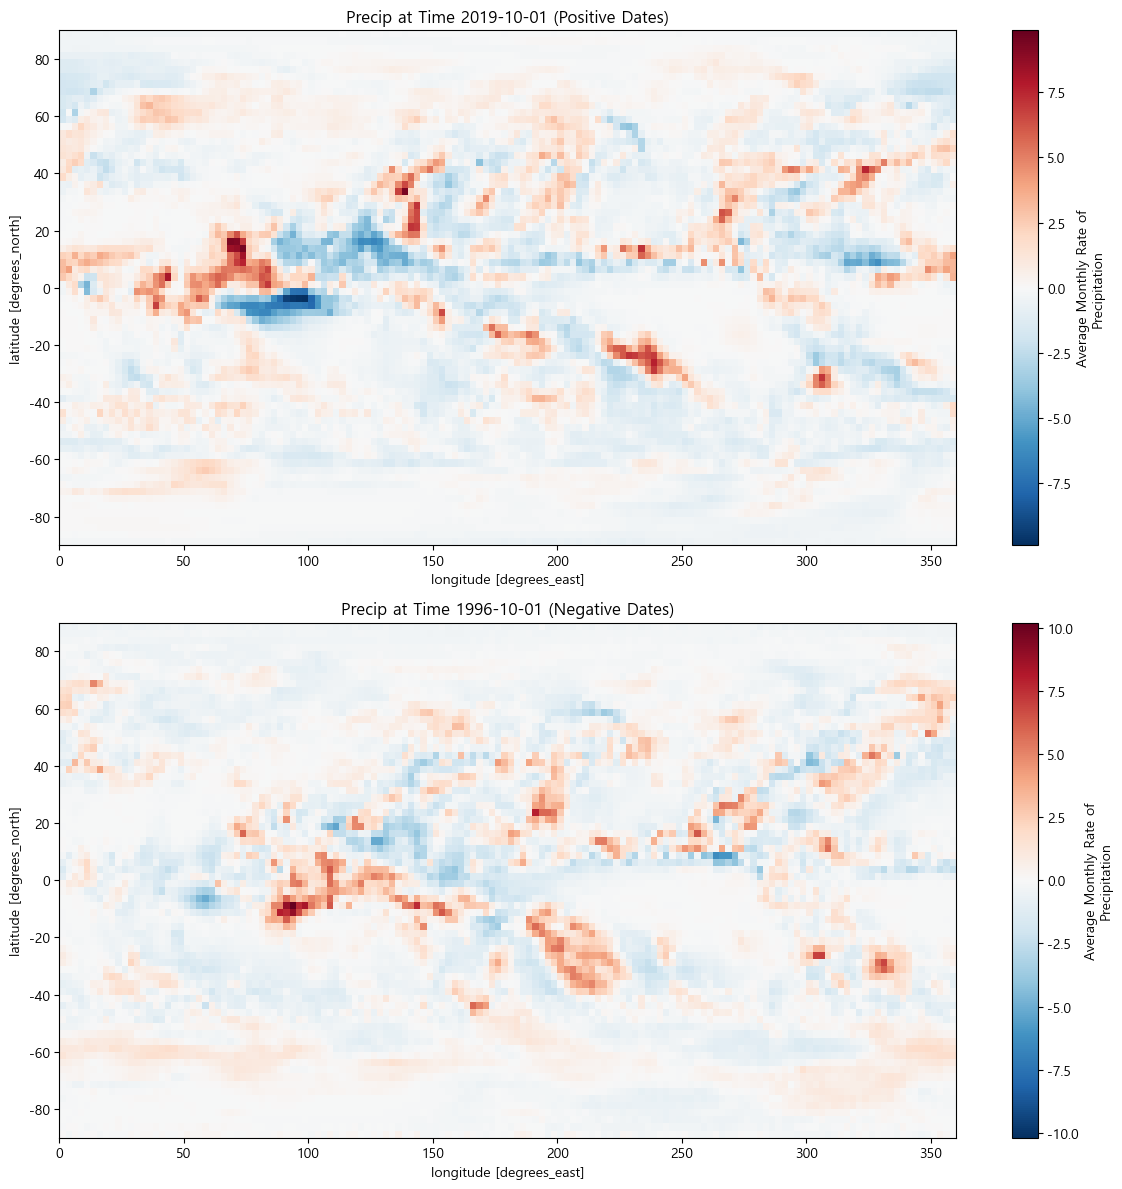

In [51]:
# positive_dates 중에서 원하는 시간에 대한 precip 데이터를 가져옵니다.
specific_date_positive = '2019-10-01'
specific_time_positive = precip['precip'].sel(time=specific_date_positive)

# negative_dates 중에서 원하는 시간에 대한 precip 데이터를 가져옵니다.
specific_date_negative = '1996-10-01'
specific_time_negative = precip['precip'].sel(time=specific_date_negative)

# 두 그래프를 하나의 이미지에 그립니다.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

specific_time_positive.plot(ax=ax1)
ax1.set_title(f'Precip at Time {specific_date_positive} (Positive Dates)')

specific_time_negative.plot(ax=ax2)
ax2.set_title(f'Precip at Time {specific_date_negative} (Negative Dates)')

plt.tight_layout()
plt.show()

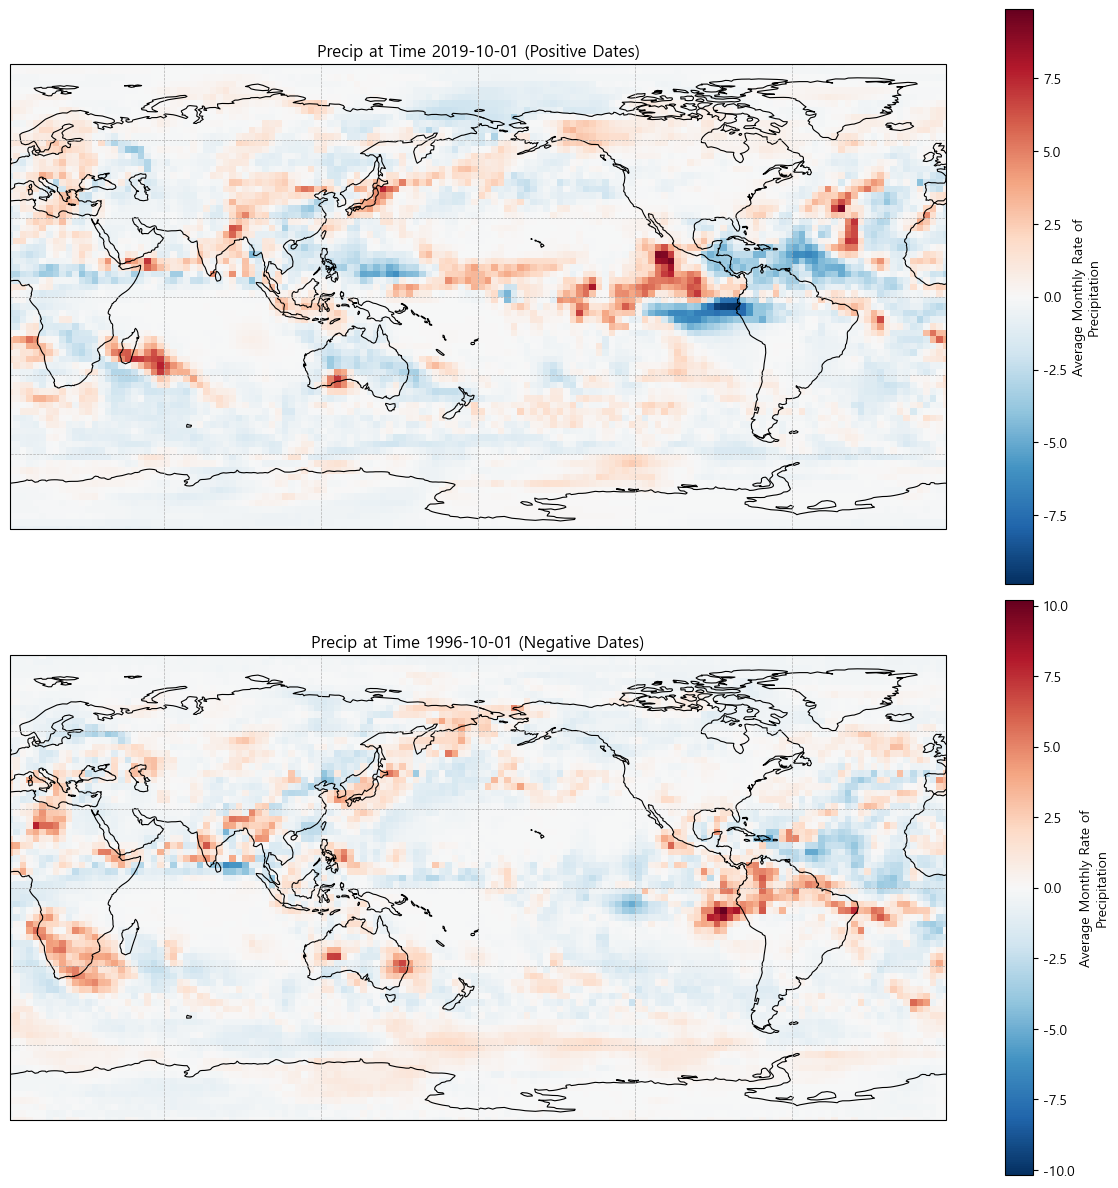

In [52]:
# positive_dates 중에서 원하는 시간에 대한 precip 데이터를 가져옵니다.
specific_date_positive = '2019-10-01'
specific_time_positive = precip['precip'].sel(time=specific_date_positive)

# negative_dates 중에서 원하는 시간에 대한 precip 데이터를 가져옵니다.
specific_date_negative = '1996-10-01'
specific_time_negative = precip['precip'].sel(time=specific_date_negative)

# subplot 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# ax1과 ax2에 지도 특성 및 해안선 추가
ax1.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax1.gridlines(linewidth=0.5, linestyle='--')
ax1.set_extent([specific_time_positive['lon'].min(), specific_time_positive['lon'].max(), specific_time_positive['lat'].min(), specific_time_positive['lat'].max()], crs=ccrs.PlateCarree())

ax2.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax2.gridlines(linewidth=0.5, linestyle='--')
ax2.set_extent([specific_time_negative['lon'].min(), specific_time_negative['lon'].max(), specific_time_negative['lat'].min(), specific_time_negative['lat'].max()], crs=ccrs.PlateCarree())

# Precip 그래프 그리기
specific_time_positive.plot(ax=ax1)
ax1.set_title(f'Precip at Time {specific_date_positive} (Positive Dates)')

specific_time_negative.plot(ax=ax2)
ax2.set_title(f'Precip at Time {specific_date_negative} (Negative Dates)')

plt.tight_layout() 
plt.show()


## iod와 sst, precip 간 상관계수

In [55]:
iod = xr.open_dataset(official_data_path+'iod.nc')

time = np.datetime_as_string(iod.time.data, unit='D')
iod_df = pd.DataFrame({'time': time, 
                       'iod' : iod.iod.values.flatten(),
                       'sst_total' : sst_mean_total,
                       'sst_wtio' : sst_mean_wtio,
                       'sst_setio' : sst_mean_setio,
                       'precip_total': precip_mean_total,
                       'precip_wtio': precip_mean_wtio,
                       'precip_setio': precip_mean_setio
                       })

iod_df.head()

time       iod  sst_total  sst_wtio  sst_setio  precip_total  \
0  1982-01-01 -0.006475  -0.147095 -0.444517  -0.453555      0.008129   
1  1982-02-01  0.525734  -0.226385 -0.189082  -0.709165     -0.040925   
2  1982-03-01  0.440154  -0.226626 -0.200384  -0.638263      0.082464   
3  1982-04-01  0.493691  -0.216846  0.099227  -0.395144      0.074364   
4  1982-05-01  0.740477  -0.206193  0.273563  -0.456466      0.017565   

   precip_wtio  precip_setio  
0    -1.142866      2.629038  
1    -0.932361     -0.413851  
2    -0.537596      0.395201  
3     0.252830     -0.056079  
4     0.525722     -1.203908

In [69]:
iod_timedrop = iod_df.drop('time', axis=1)

In [71]:
# 전체 상관계수
iod_timedrop.corr()

iod  sst_total  sst_wtio  sst_setio  precip_total  \
iod           1.000000   0.104678  0.492519  -0.590171     -0.076616   
sst_total     0.104678   1.000000  0.687889   0.529332      0.133219   
sst_wtio      0.492519   0.687889  1.000000   0.411706      0.166963   
sst_setio    -0.590171   0.529332  0.411706   1.000000      0.235075   
precip_total -0.076616   0.133219  0.166963   0.235075      1.000000   
precip_wtio   0.298019   0.256999  0.384635   0.043517      0.204340   
precip_setio -0.506287  -0.010946 -0.203449   0.342651      0.066120   

              precip_wtio  precip_setio  
iod              0.298019     -0.506287  
sst_total        0.256999     -0.010946  
sst_wtio         0.384635     -0.203449  
sst_setio        0.043517      0.342651  
precip_total     0.204340      0.066120  
precip_wtio      1.000000     -0.281210  
precip_setio    -0.281210      1.000000

<Axes: >

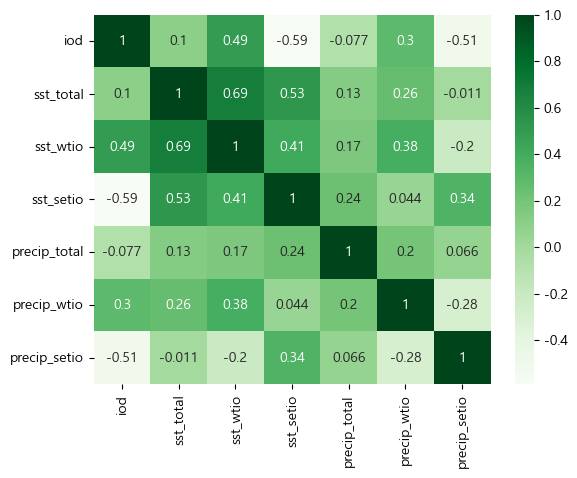

In [72]:
sns.heatmap(iod_timedrop.corr(), annot=True, cmap='Greens')

<Axes: >

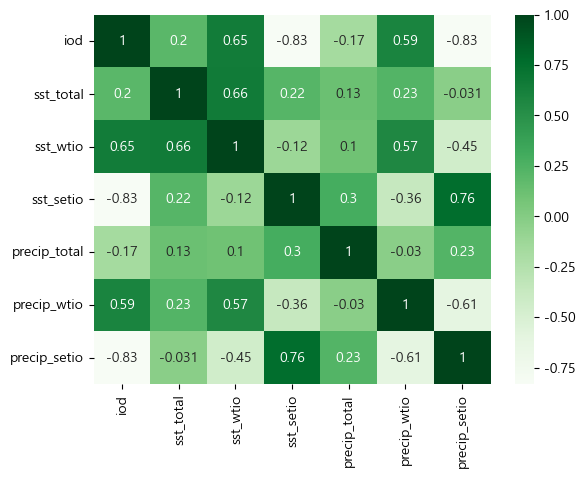

In [75]:
# 이벤트 기간만 뽑아서 상관계수 계산
event_data = iod_df[iod_df['time'].isin(all_event_dates)]
event_data_timedrop = event_data.drop('time', axis=1)
sns.heatmap(event_data_timedrop.corr(), annot=True, cmap='Greens')

<Axes: >

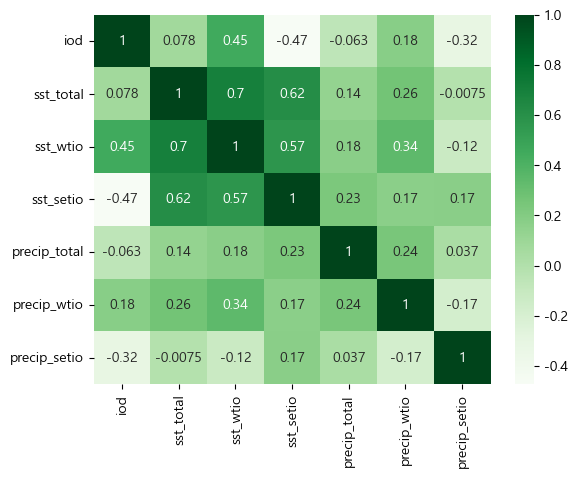

In [76]:
# 이벤트 기간이 아닐때 상관계수 계산
non_event_data = iod_df[iod_df['time'].isin(non_event_dates)]
non_event_data_timedrop = non_event_data.drop('time', axis=1)
sns.heatmap(non_event_data_timedrop.corr(), annot=True, cmap='Greens')

In [79]:
event_data_timedrop.corr()

iod  sst_total  sst_wtio  sst_setio  precip_total  \
iod           1.000000   0.203123  0.650387  -0.833037     -0.169978   
sst_total     0.203123   1.000000  0.662319   0.219085      0.125984   
sst_wtio      0.650387   0.662319  1.000000  -0.121783      0.103895   
sst_setio    -0.833037   0.219085 -0.121783   1.000000      0.297188   
precip_total -0.169978   0.125984  0.103895   0.297188      1.000000   
precip_wtio   0.592609   0.232336  0.566659  -0.362170     -0.030002   
precip_setio -0.830166  -0.031045 -0.445279   0.760120      0.232704   

              precip_wtio  precip_setio  
iod              0.592609     -0.830166  
sst_total        0.232336     -0.031045  
sst_wtio         0.566659     -0.445279  
sst_setio       -0.362170      0.760120  
precip_total    -0.030002      0.232704  
precip_wtio      1.000000     -0.605894  
precip_setio    -0.605894      1.000000

# 추가

sst 인도양 범위

* 서인도양 50-70˚E, 10˚S-10˚N
* 남동인도양 90-110˚E, 10˚S-적도



In [ ]:
# import matplotlib.patches as mpatches

In [ ]:
# for time_step in positive_event_dates:
#     sst_cut = sst.sel(lat=slice(-20, 20), lon=slice(40, 120), time=time_step)

#     fig = plt.figure(figsize=(12, 6))
#     ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

#     sst_cut.sst.plot()
#     ax.coastlines()

#     plt.title(time_step)

#     #범위 표기
#     lon1, lon2, lat1, lat2 = 50, 70, 10, -10
#     vertices = [(lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2)]

#     polygon2 = mpatches.Polygon(vertices, closed=True, edgecolor='r', facecolor='none', transform=ccrs.PlateCarree())
#     ax.add_patch(polygon2)

#     lon1, lon2, lat1, lat2 = 90, 110, -10, 0
#     vertices = [(lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2)]

#     polygon = mpatches.Polygon(vertices, closed=True, edgecolor='b', facecolor='none', transform=ccrs.PlateCarree())
#     ax.add_patch(polygon)

#     plt.savefig(f'graph/sst_pos/sst_pos_{time_step}.png', bbox_inches='tight', pad_inches=0.1)

#     plt.close()

In [ ]:
# for time_step in negative_event_dates:
#     sst_cut = sst.sel(lat=slice(-20, 20), lon=slice(40, 120), time=time_step)

#     fig = plt.figure(figsize=(12, 6))
#     ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

#     sst_cut.sst.plot()
#     ax.coastlines()

#     plt.title(time_step)

#     #범위 표기
#     lon1, lon2, lat1, lat2 = 50, 70, 10, -10
#     vertices = [(lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2)]

#     polygon2 = mpatches.Polygon(vertices, closed=True, edgecolor='r', facecolor='none', transform=ccrs.PlateCarree())
#     ax.add_patch(polygon2)

#     lon1, lon2, lat1, lat2 = 90, 110, -10, 0
#     vertices = [(lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2)]

#     polygon = mpatches.Polygon(vertices, closed=True, edgecolor='b', facecolor='none', transform=ccrs.PlateCarree())
#     ax.add_patch(polygon)

#     plt.savefig(f'graph/sst_neg/sst_neg_{time_step}.png', bbox_inches='tight', pad_inches=0.1)

#     plt.close()

In [80]:
positive_event_dates
negative_event_dates
non_event_dates

['1982-01-01',
 '1982-02-01',
 '1982-03-01',
 '1982-12-01',
 '1983-01-01',
 '1983-02-01',
 '1983-03-01',
 '1983-05-01',
 '1983-06-01',
 '1983-07-01',
 '1983-09-01',
 '1983-10-01',
 '1983-11-01',
 '1983-12-01',
 '1984-01-01',
 '1984-02-01',
 '1984-03-01',
 '1984-04-01',
 '1984-05-01',
 '1984-06-01',
 '1984-07-01',
 '1984-08-01',
 '1984-09-01',
 '1984-10-01',
 '1984-11-01',
 '1984-12-01',
 '1985-01-01',
 '1985-02-01',
 '1985-03-01',
 '1985-04-01',
 '1985-05-01',
 '1985-06-01',
 '1985-07-01',
 '1985-08-01',
 '1985-09-01',
 '1985-10-01',
 '1985-11-01',
 '1985-12-01',
 '1986-01-01',
 '1986-02-01',
 '1986-03-01',
 '1986-04-01',
 '1986-05-01',
 '1986-06-01',
 '1986-07-01',
 '1986-08-01',
 '1986-09-01',
 '1986-10-01',
 '1986-11-01',
 '1986-12-01',
 '1987-01-01',
 '1987-02-01',
 '1987-03-01',
 '1987-04-01',
 '1987-05-01',
 '1987-06-01',
 '1987-07-01',
 '1987-08-01',
 '1987-09-01',
 '1987-10-01',
 '1987-11-01',
 '1987-12-01',
 '1988-01-01',
 '1988-02-01',
 '1988-03-01',
 '1988-04-01',
 '1988-05-